# Internal-External Development and Cross-Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Using github PAT from envvar GITHUB_TOKEN. Use `gitcreds::gitcreds_set()` and unset GITHUB_TOKEN in .Renviron (or elsewhere) if you want to use the more secure git credential store instead.
Skipping install of 'calibrationHelper' from a github remote, the SHA1 (180c7c77) has not changed since last install.
  Use `force = TRUE` to force installation

# Logistic Model 1_A

In [ ]:
library(rsample) # for group_vfold_cv()
library(furrr) # for future_map()

Loading required package: future

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

Loading required package: rms

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following object is masked from 'package:parsnip':

    translate

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
# library(probably)

# perf_test <- valProbggplot(predictions_full$.pred_TRUE, predictions_full$truth |> as.logical(), logistic.cal = TRUE, smooth = "none")

# predictions_full |> cal_plot_logistic(truth = truth, estimate = starts_with(".pred"), event_level = "first")

In [ ]:
# Function to modify sample data and fit model
fit_model_to_sample <- function(sample, variables) {
  data <- analysis(sample) |>
    mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID))

  formula <- reformulate(termlabels = variables, response = "flag_ADR_TP_ID")

  logistic_reg() |>
    set_engine("glm") |>
    set_mode("classification") |>
    fit(formula, data = data)
}

calc_cross_performance <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model$fit, data, type = "response")
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, smooth = "none")

  tibble(
    site = data$site[1],
    n = nrow(data),
    cross_C_index = calperf$Cindex[[1]],
    cross_C_index_lower = calperf$Cindex[[2]],
    cross_C_index_upper = calperf$Cindex[[3]],
    cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
    cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
    cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
    cross_calibration_slope = calperf$Calibration$Slope[[1]],
    cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
    cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
  )
}

plot_calibration_curve <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model$fit, data, type = "response")
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 1, col.log = "blue", smooth = "none")
  calperf$ggPlot + ggtitle(data$site[1])
}

# Fit model to each sample
# cross_full_HPM <- map2(cross_samples$splits, cross_predict_HPM, fit_model_to_sample)
cross_full_BPM <- map2(cross_samples$splits, cross_predict_BPM, fit_model_to_sample)

# cross_estimates_HPM <- map2_dfr(cross_samples$splits, cross_full_HPM, calc_cross_performance)
cross_estimates_BPM <- map2_dfr(cross_samples$splits, cross_full_BPM, calc_cross_performance)

# cross_plots_HPM <- map2(cross_samples$splits, cross_full_HPM, plot_calibration_curve)
cross_plots_BPM <- map2(cross_samples$splits, cross_full_BPM, plot_calibration_curve)

[[1]]

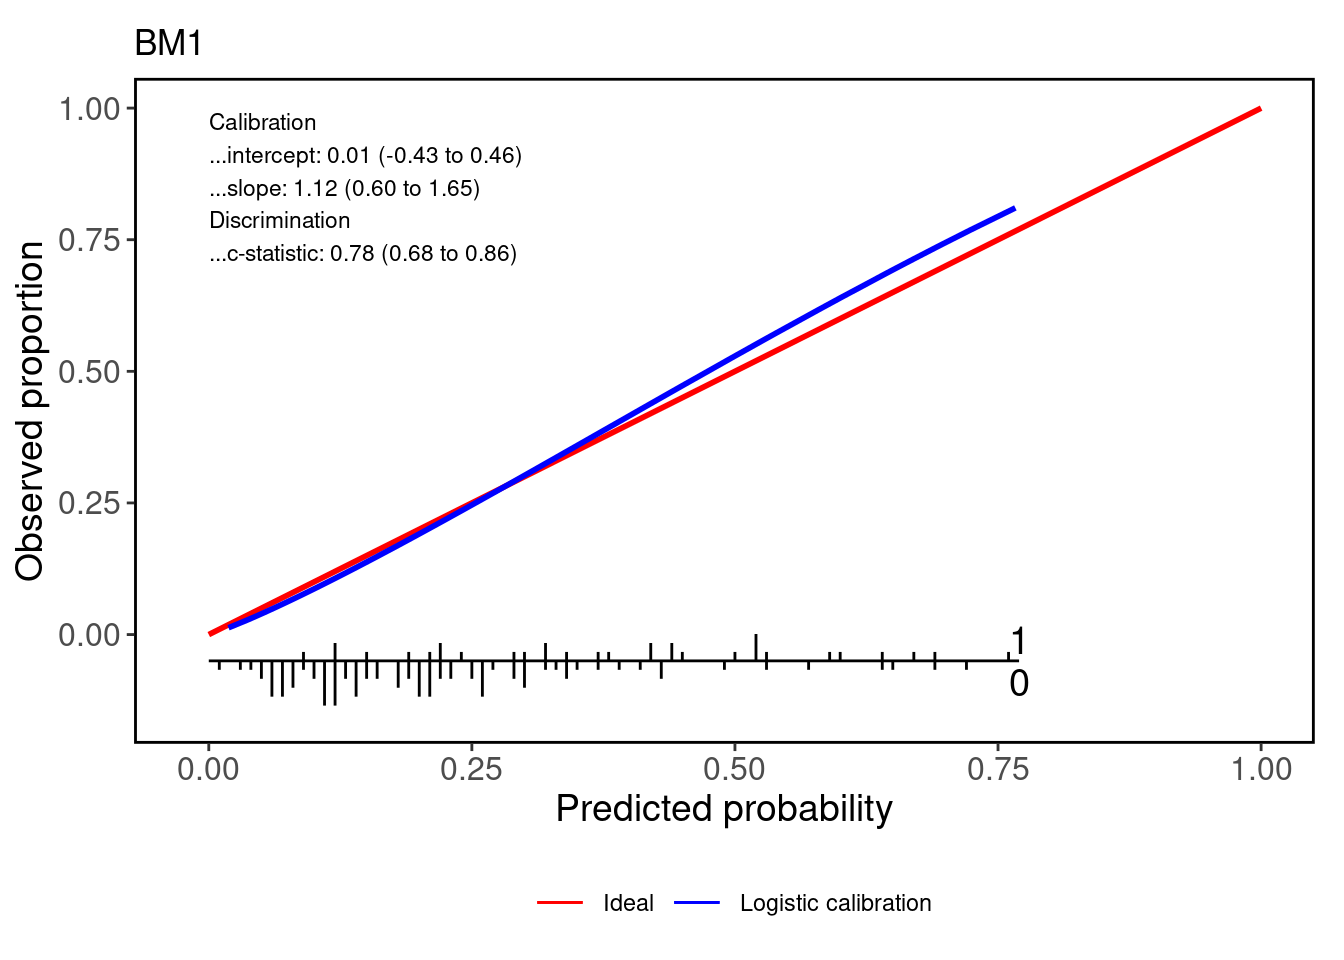


[[2]]

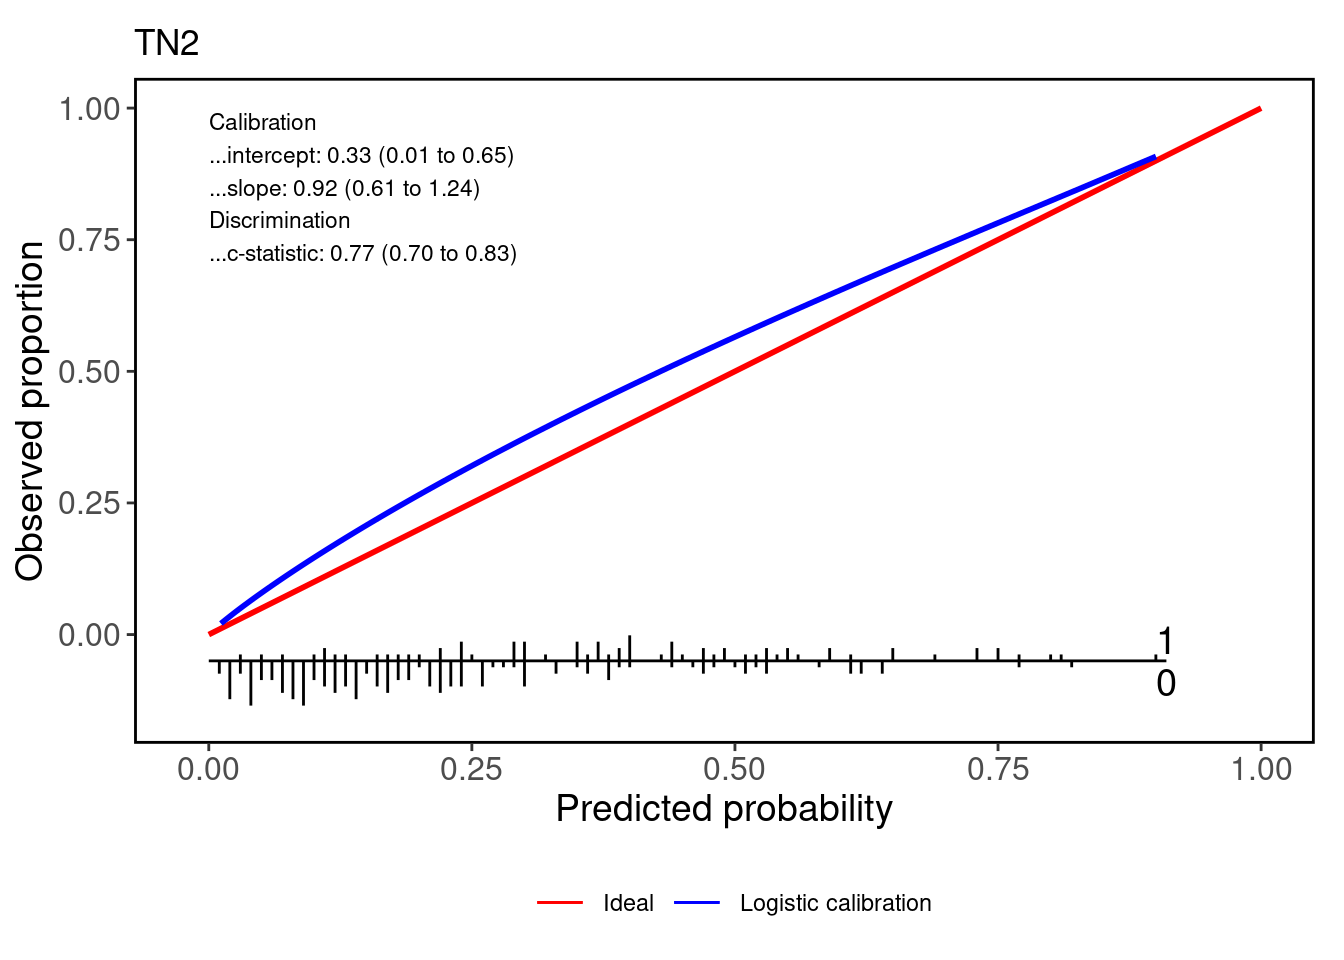


[[3]]

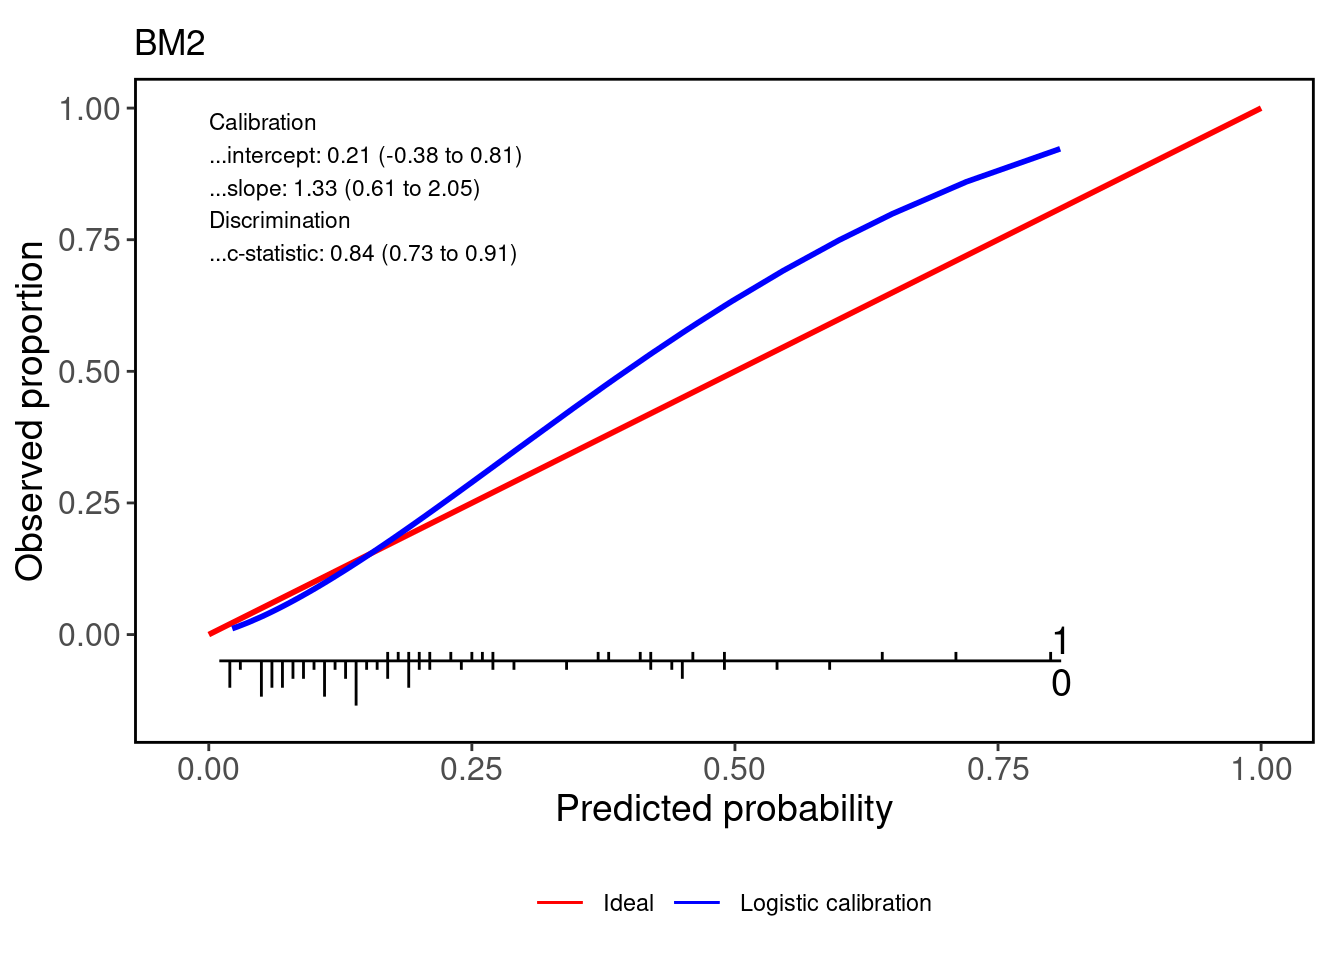


[[4]]

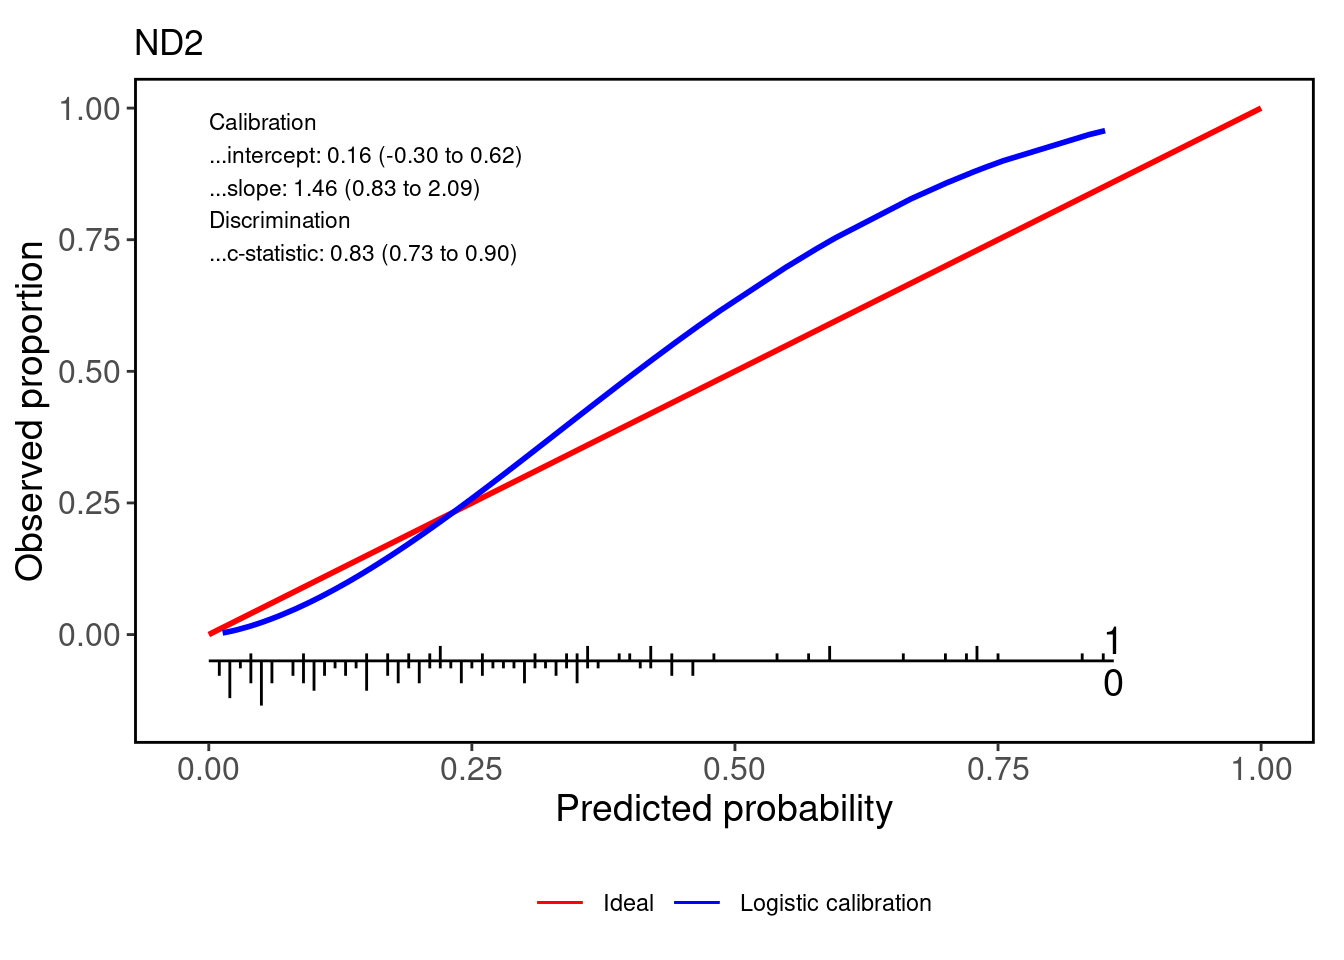


[[5]]

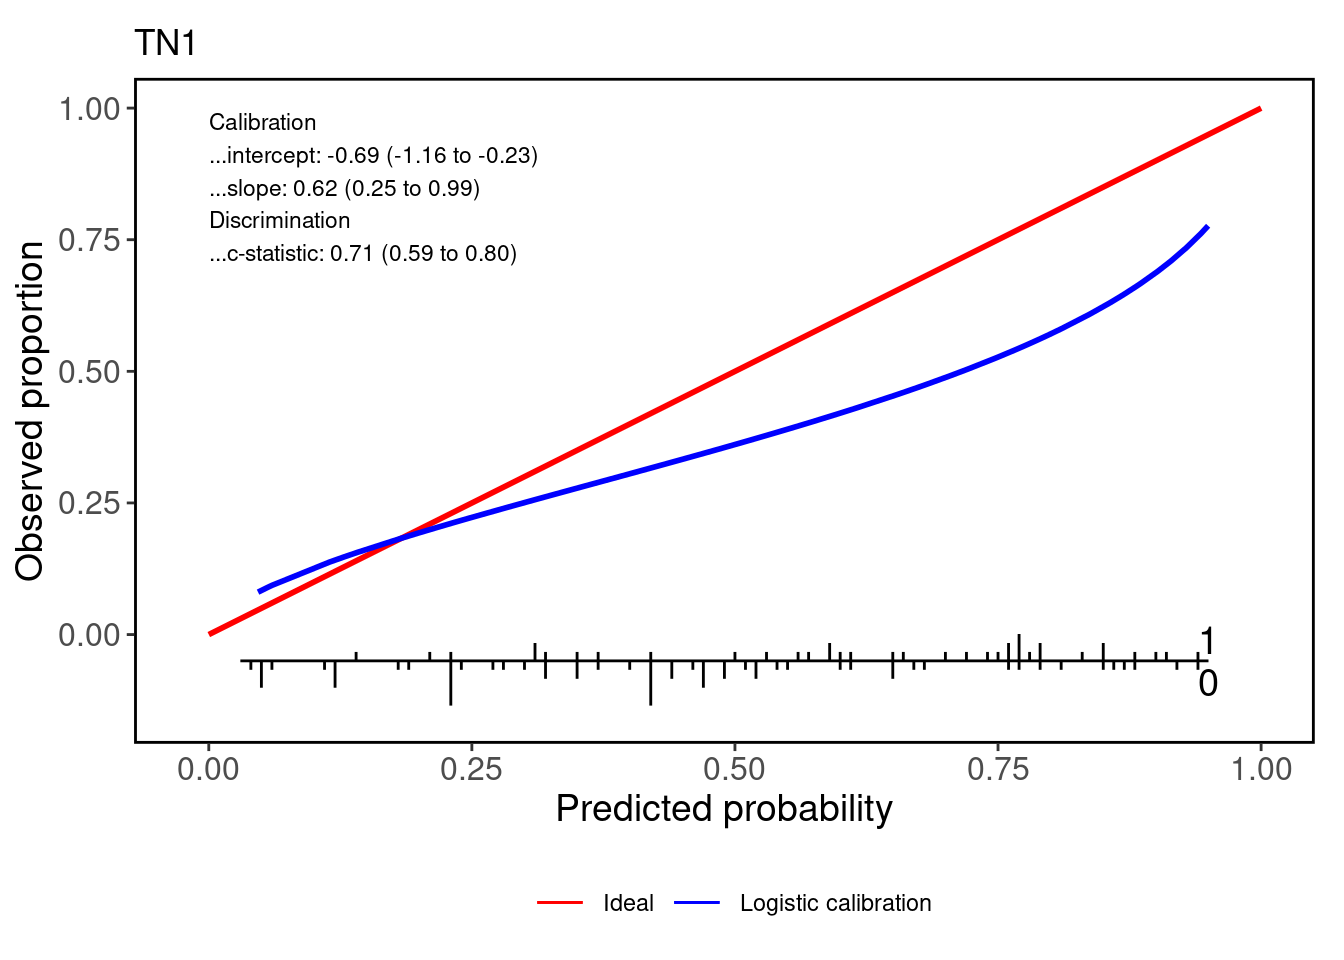


[[6]]

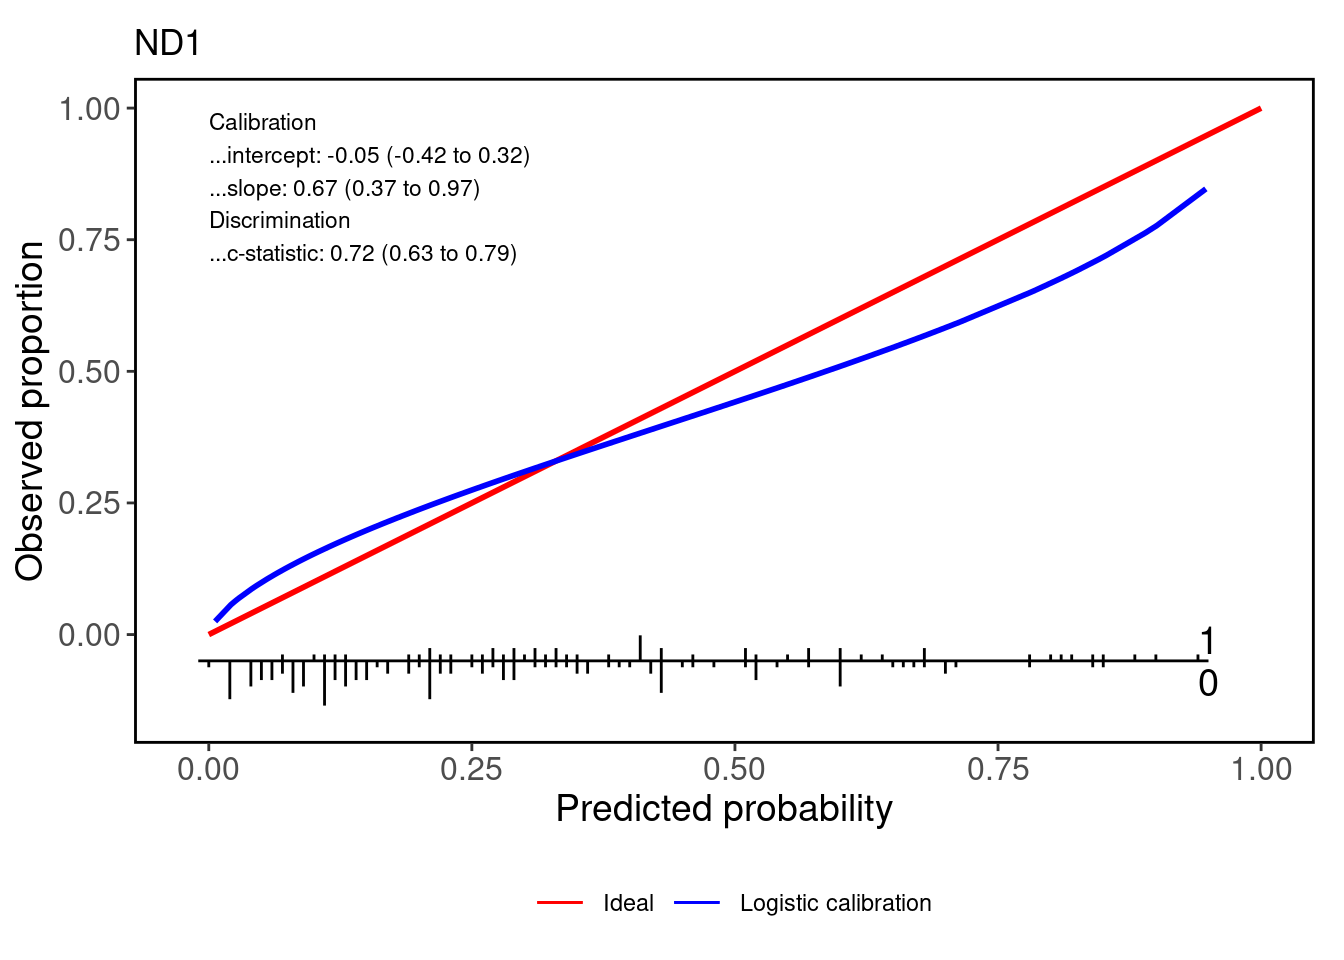

In [ ]:
cross_plots_BPM

In [ ]:
# cross_plots_HPM

In [ ]:
library(meta)

Loading required package: metadat

Loading 'meta' package (version 7.0-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs

In [ ]:
# library(forestploter)

In [ ]:
# source("https://raw.githubusercontent.com/mhahsler/fit_dist/master/fit_dist.R")

# library(fitdistrplus)

# beta_dist <- fit_dist(
#   predictions_full$.pred_TRUE,
#   distribution = "beta",
#   plot = FALSE
# ) |>
#   _$beta$estimate |>
#   as.numeric()

# detach("package:fitdistrplus", unload = TRUE, force = TRUE)
# detach("package:MASS")

# library(pmvalsampsize)

# # recommended sample size
# pmvalsampsize(
#   type = "b",
#   oeciwidth = 0.3,
#   cslope = 1,
#   csciwidth = 0.3,
#   cstatistic = 0.78,
#   cstatciwidth = 0.1,
#   lpbeta = beta_dist,
#   graph = TRUE,
#   prevalence = 0.37,
#   threshold = 0.318
# )

# # practical sample size
# pmvalsampsize(
#   type = "b",
#   oeciwidth = 0.4,
#   cslope = 1,
#   csciwidth = 0.6,
#   cstatistic = 0.78,
#   cstatciwidth = 0.12,
#   lpbeta = beta_dist,
#   graph = TRUE,
#   prevalence = 0.37
# )

[1] 0.0008626331

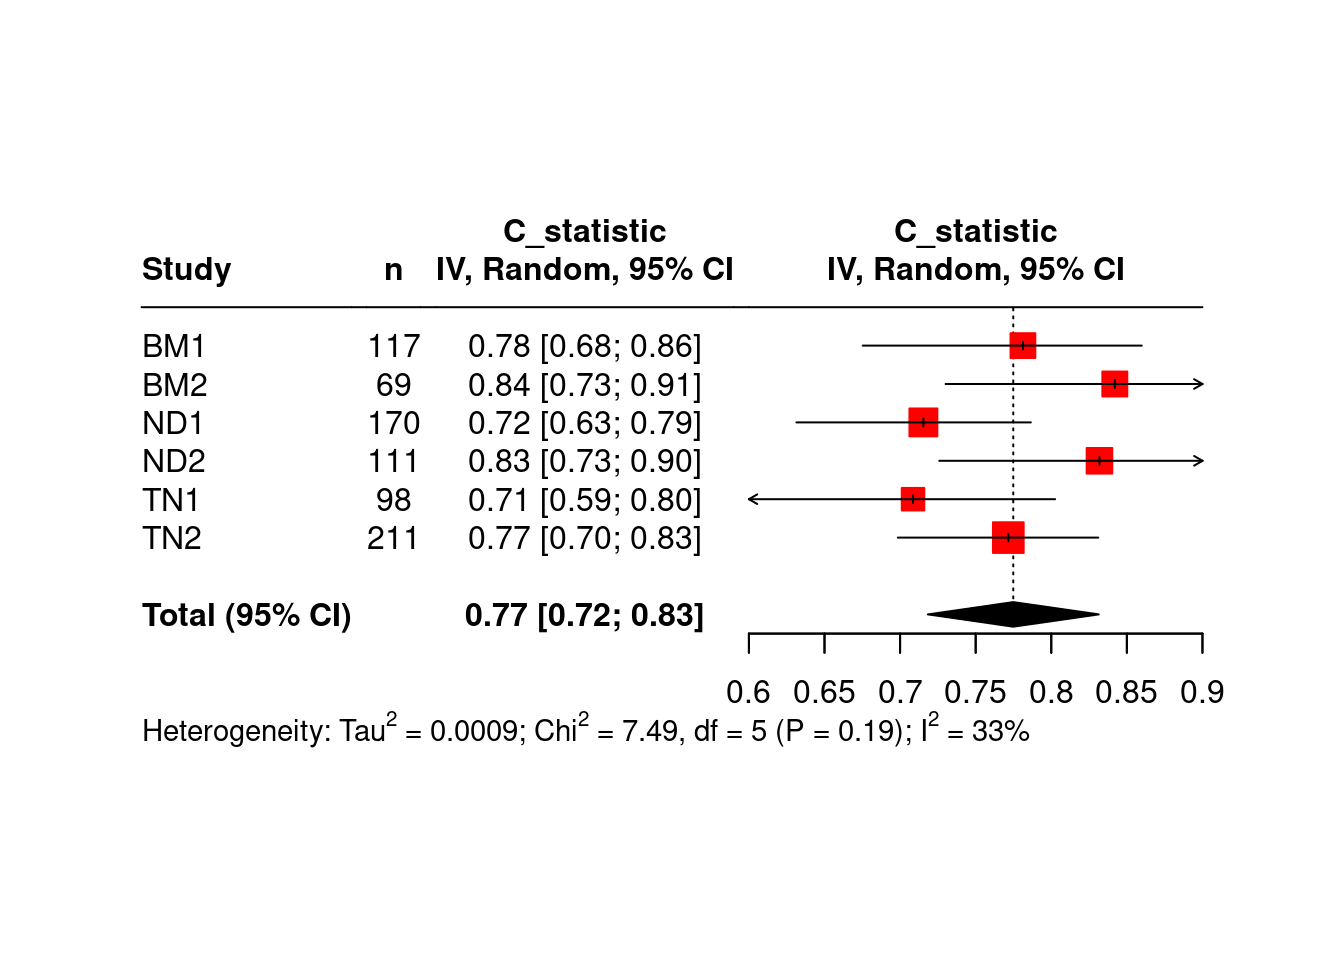

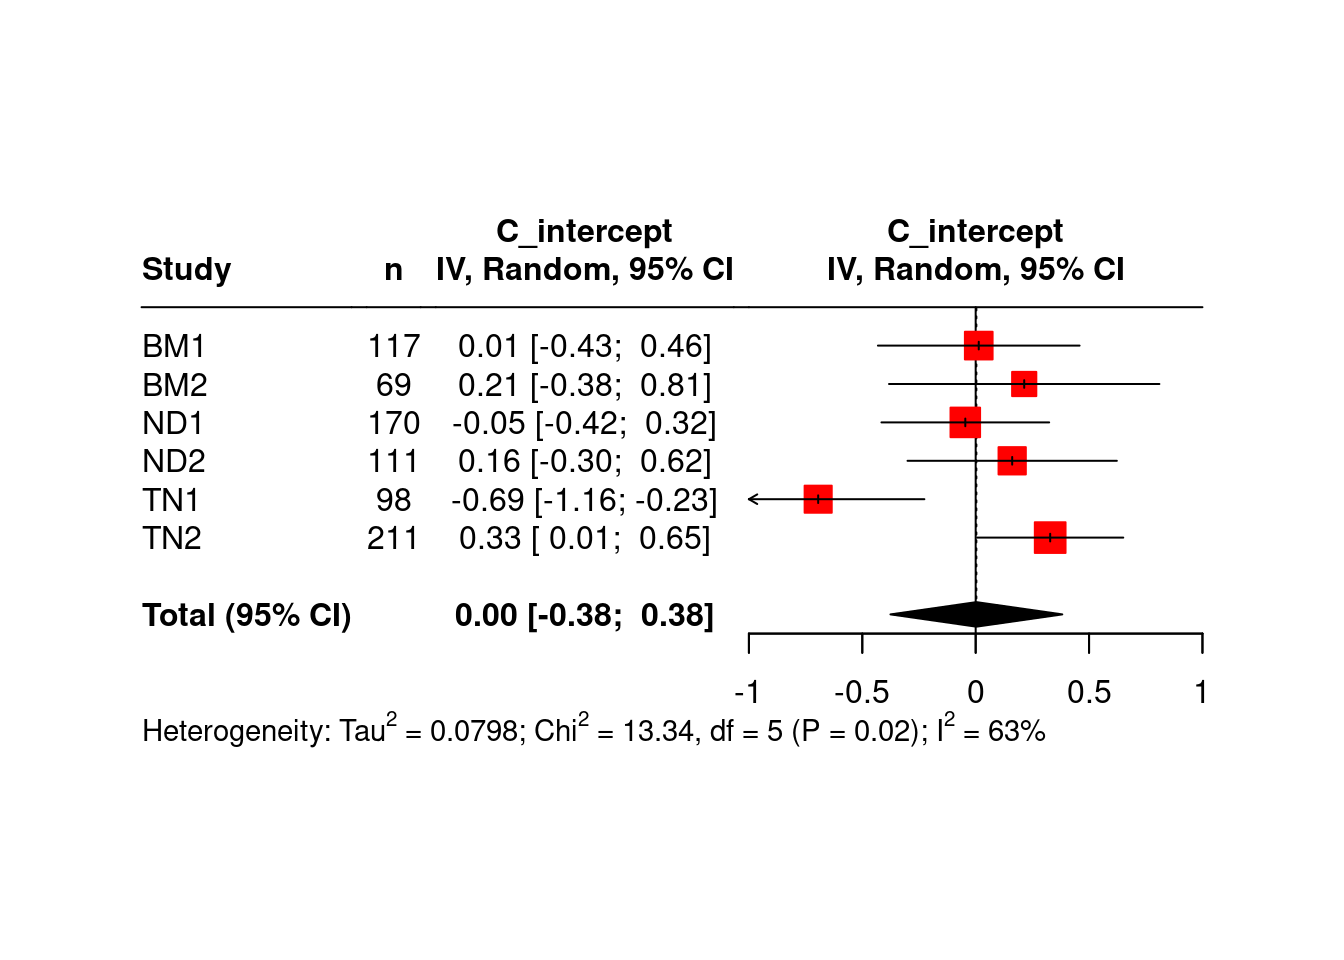

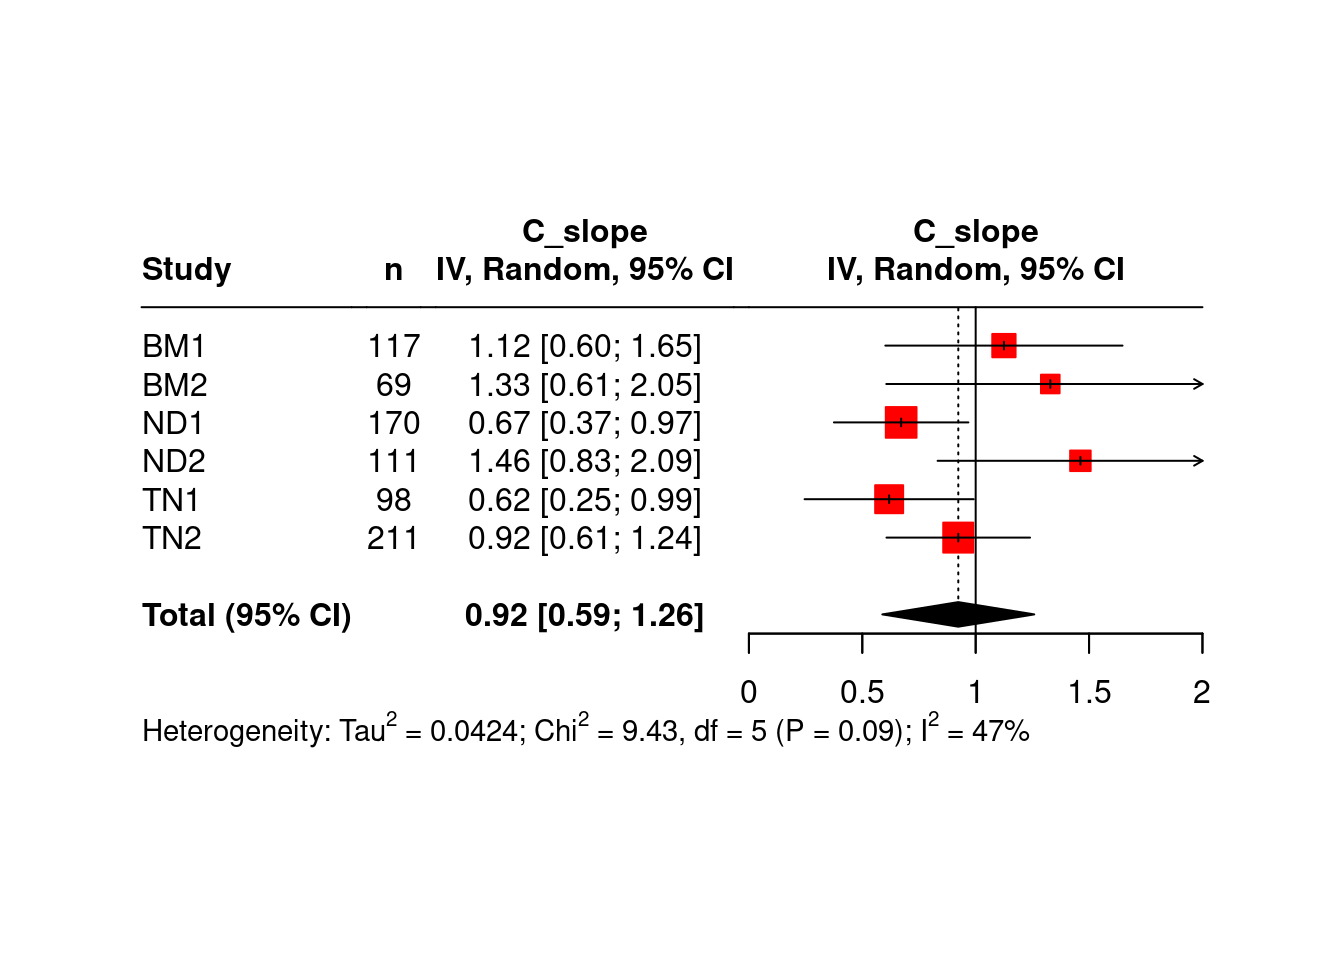

In [ ]:
library(meta)

cross_C_index_meta_BPM <- metagen(
  data = cross_estimates_BPM,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

cross_C_index_meta_BPM$tau2

In [ ]:
# save(cross_performance_metrics_HPM, file = "data/model-performance/cross-performance-metrics-HPM.rda")
save(cross_performance_metrics_BPM, file = "data/model-performance/cross-performance-metrics-BPM.rda")

# BMA Black Box (from “consensus” variables)

[[1]]

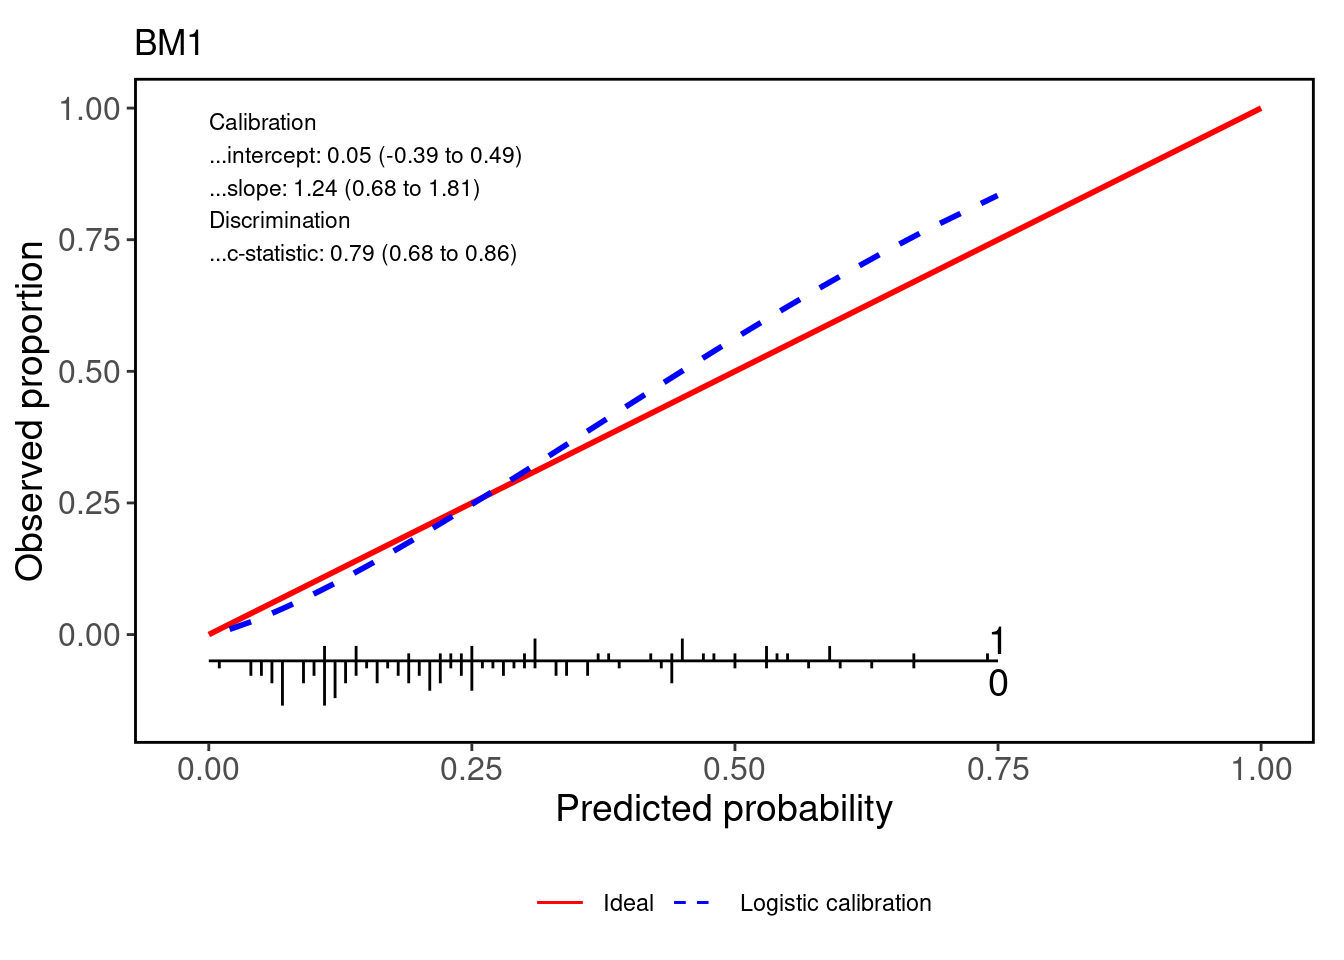


[[2]]

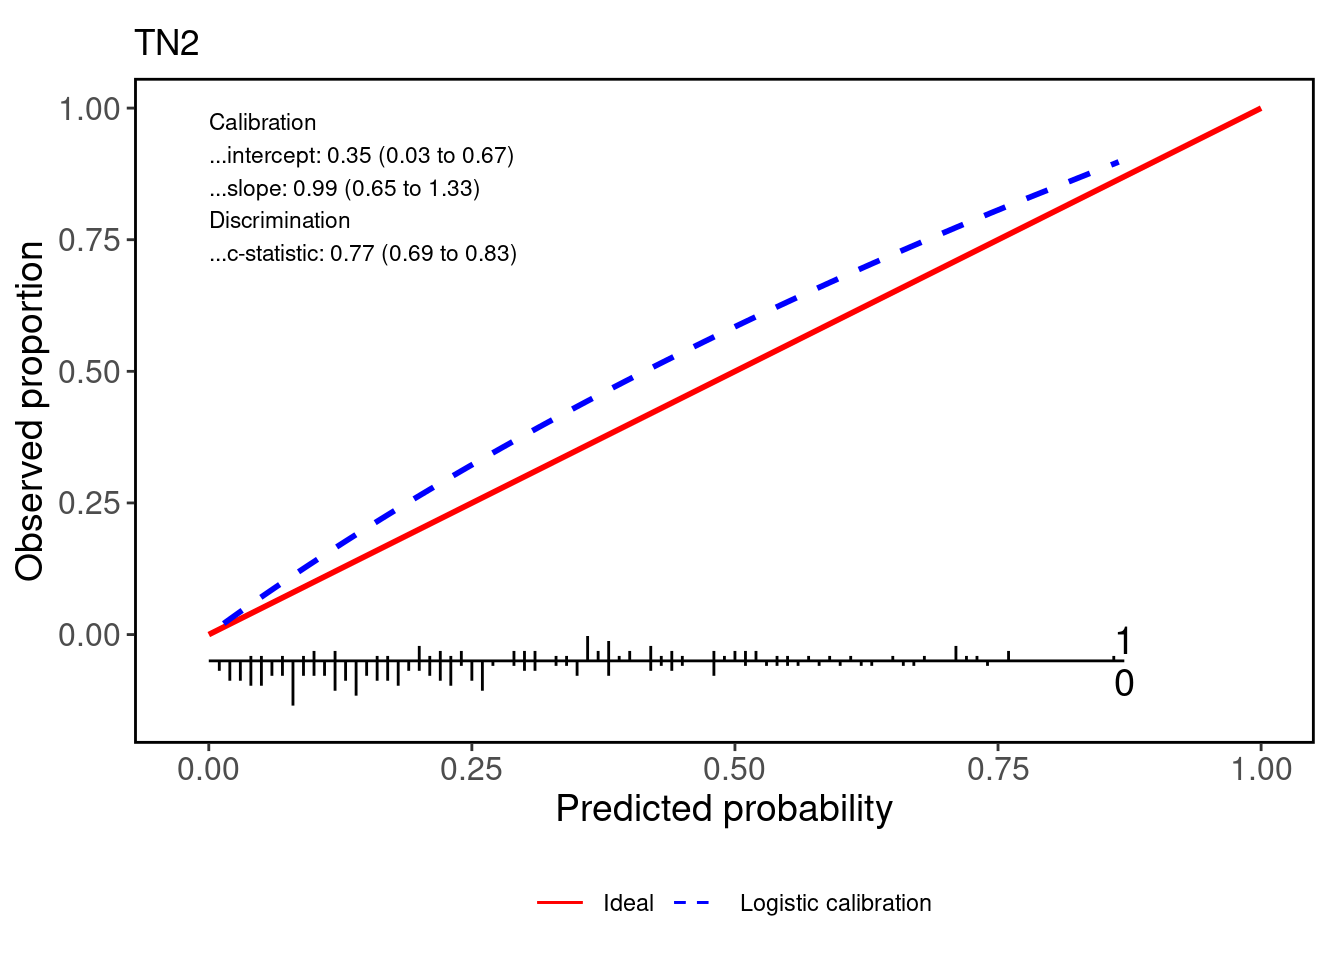


[[3]]

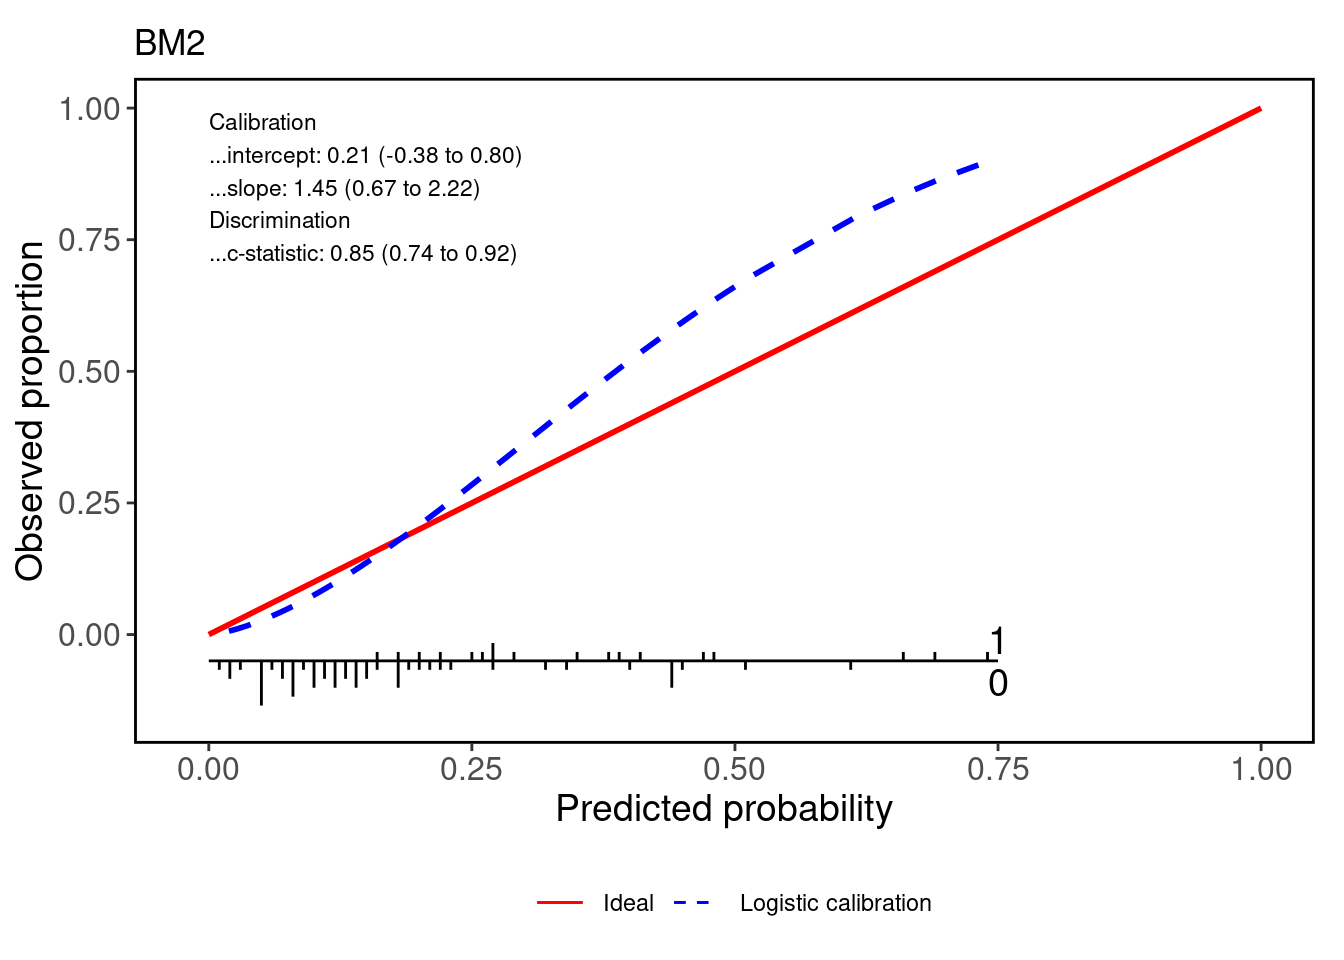


[[4]]

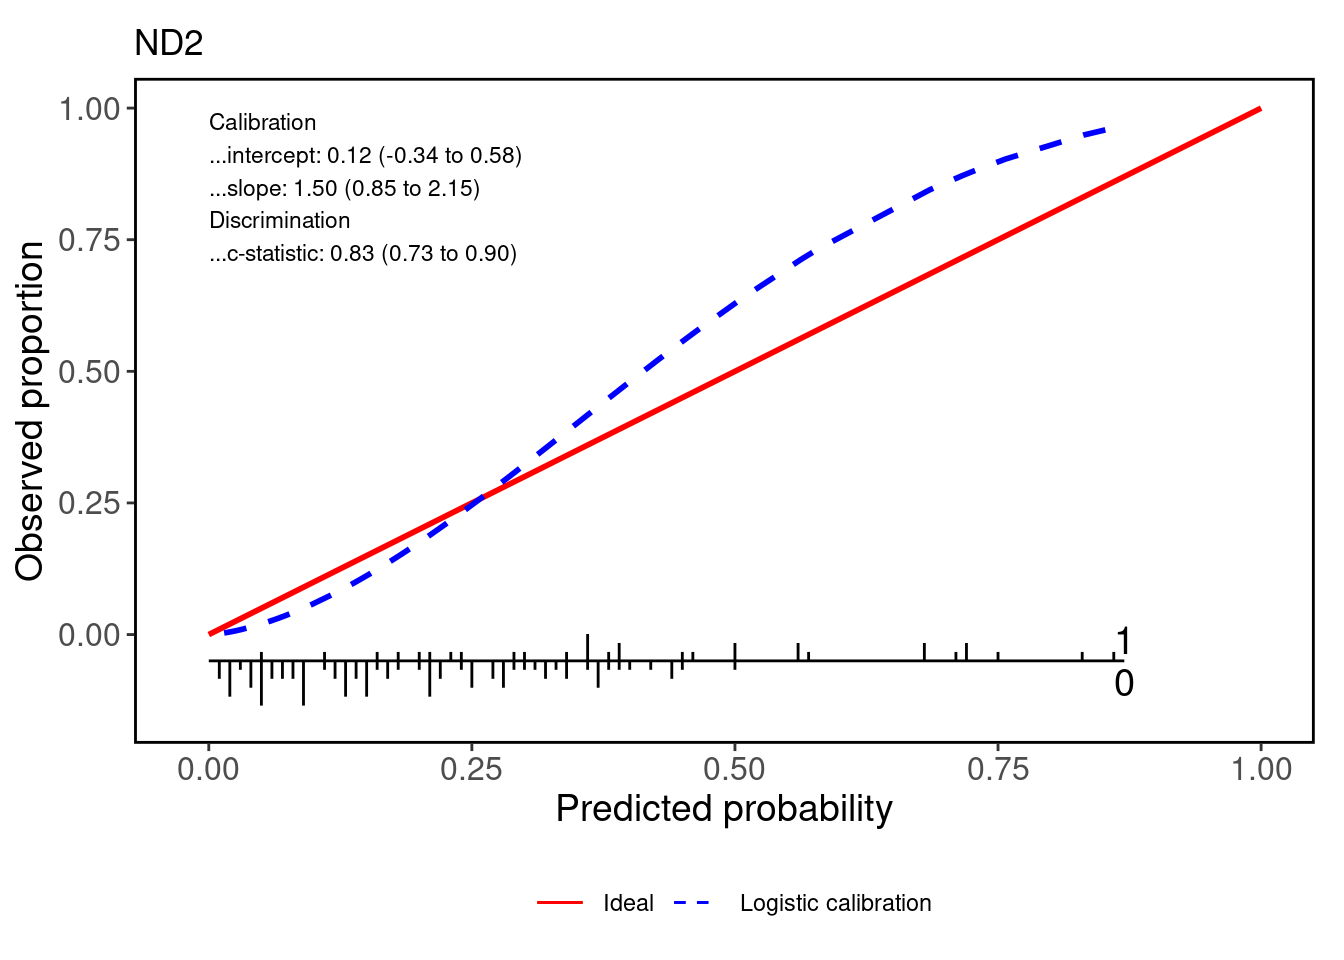


[[5]]

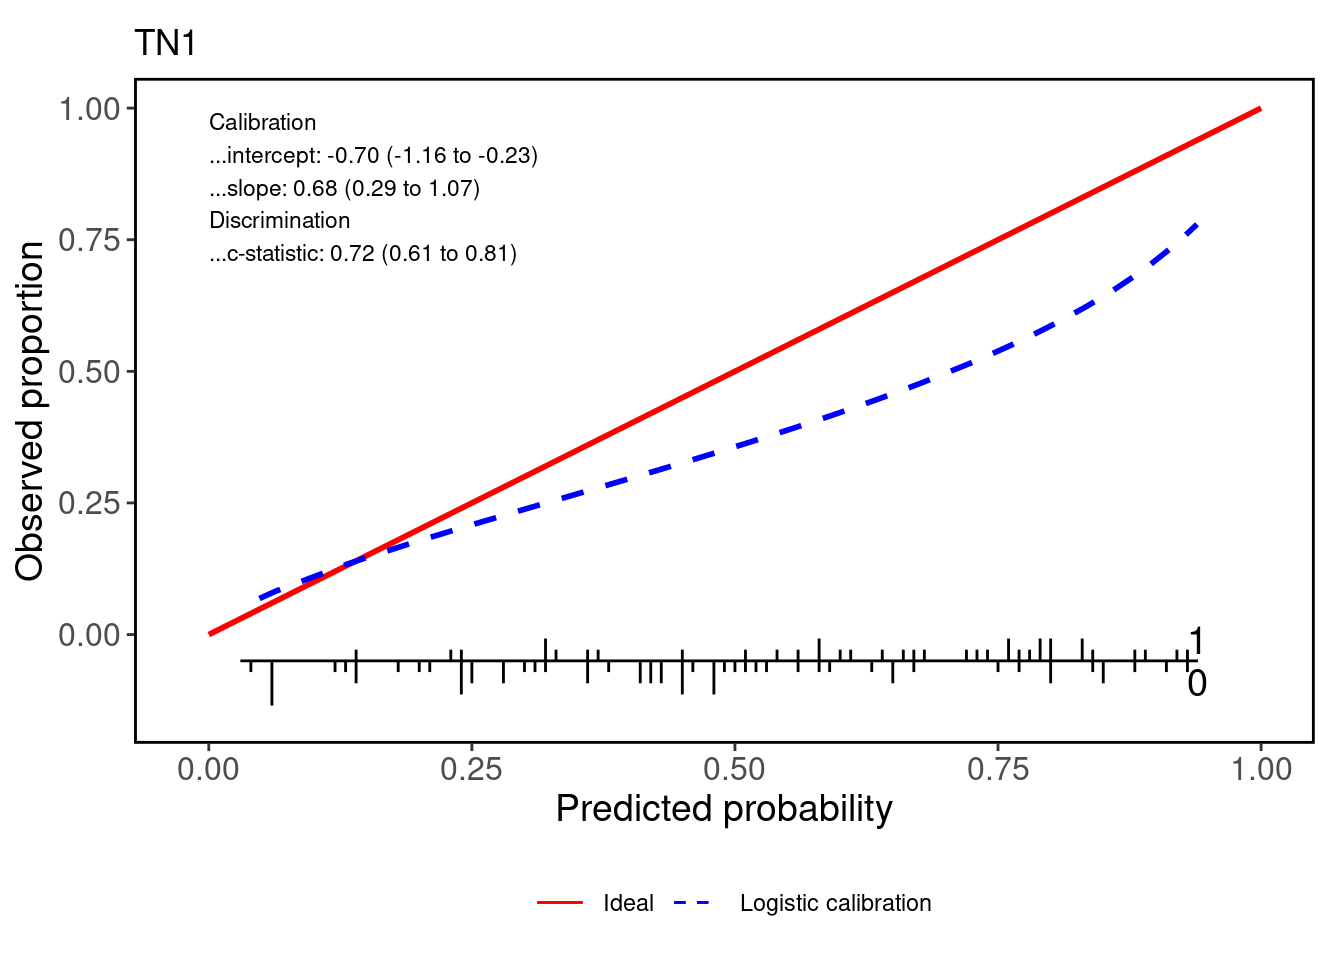


[[6]]

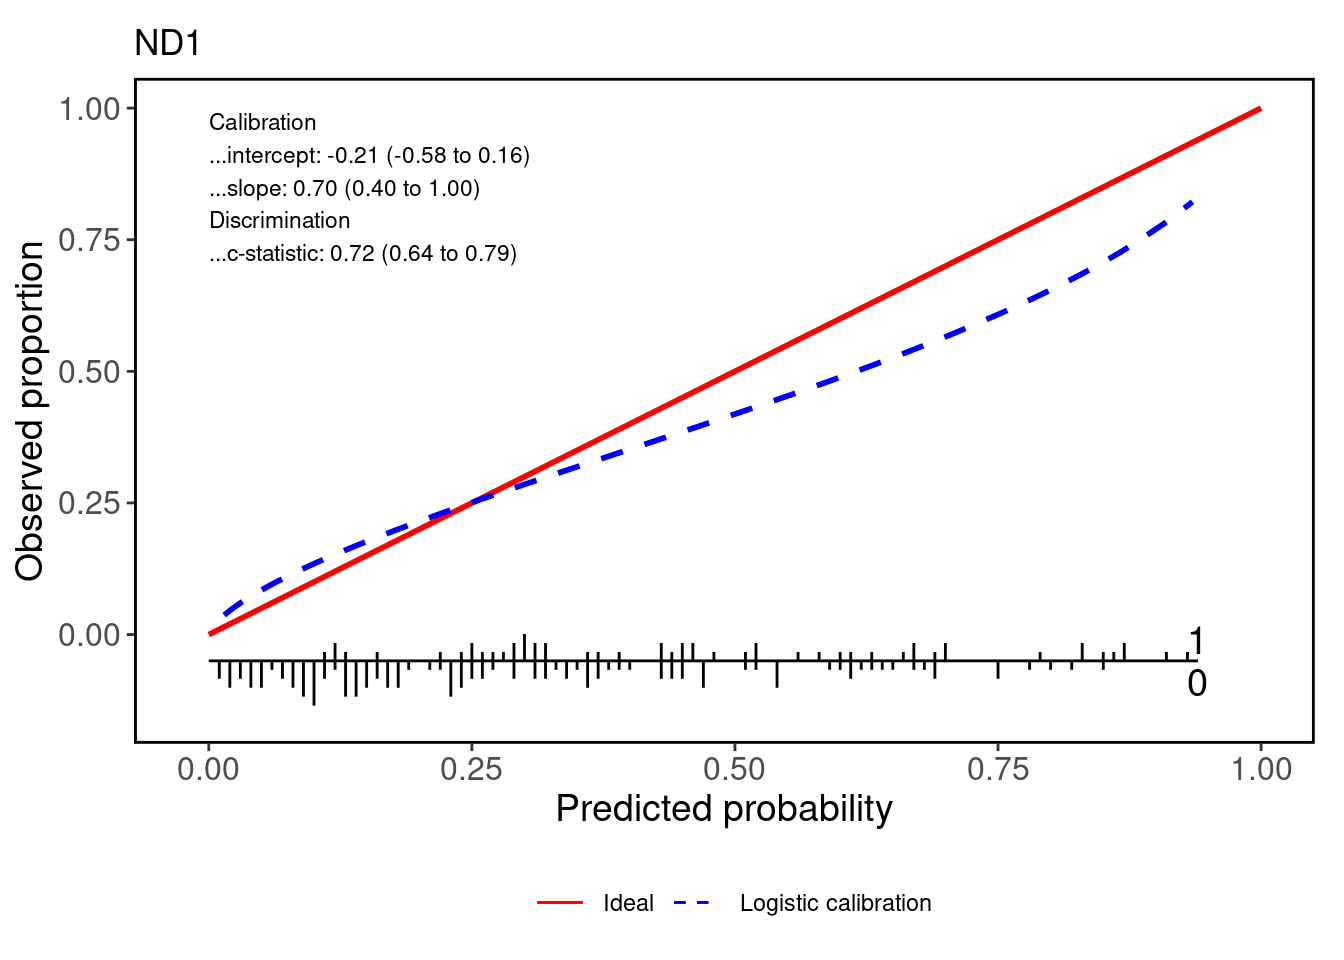

In [ ]:
run_workflow_black_box <- function(sample, model) {
  validation <- predict(model, newdata = assessment(sample), type = "response") |>
    _$fit |>
    as_tibble() |>
    rename(.pred_TRUE = value) |>
    mutate(
      .pred_FALSE = 1 - .pred_TRUE,
      truth = assessment(sample)$flag_ADR_TP_ID |> as.factor()
    ) |>
    relocate(.pred_FALSE)

  auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
  intercept <- cal_intercept(validation, truth, .pred_FALSE)
  slope <- cal_slope(validation, truth, .pred_FALSE)
  bind_rows(auc, intercept, slope)
}

workflow_results_BMA <- map2(cross_samples$splits, cross_black_box, run_workflow_black_box) |>
  set_names(cross_predict_site) |>
  bind_rows(.id = "site") |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate)

calc_cross_performance_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, smooth = "none")

  tibble(
    site = data$site[1],
    n = nrow(data),
    cross_C_index = calperf$Cindex[[1]],
    cross_C_index_lower = calperf$Cindex[[2]],
    cross_C_index_upper = calperf$Cindex[[3]],
    cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
    cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
    cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
    cross_calibration_slope = calperf$Calibration$Slope[[1]],
    cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
    cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
  )
}

cross_estimates_BMA <- map2_dfr(cross_samples$splits, cross_black_box, calc_cross_performance_black_box)

plot_calibration_curve_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
  calperf$ggPlot + ggtitle(data$site[1])
}

cross_plots_BMA <- map2(cross_samples$splits, cross_black_box, plot_calibration_curve_black_box)

cross_plots_BMA

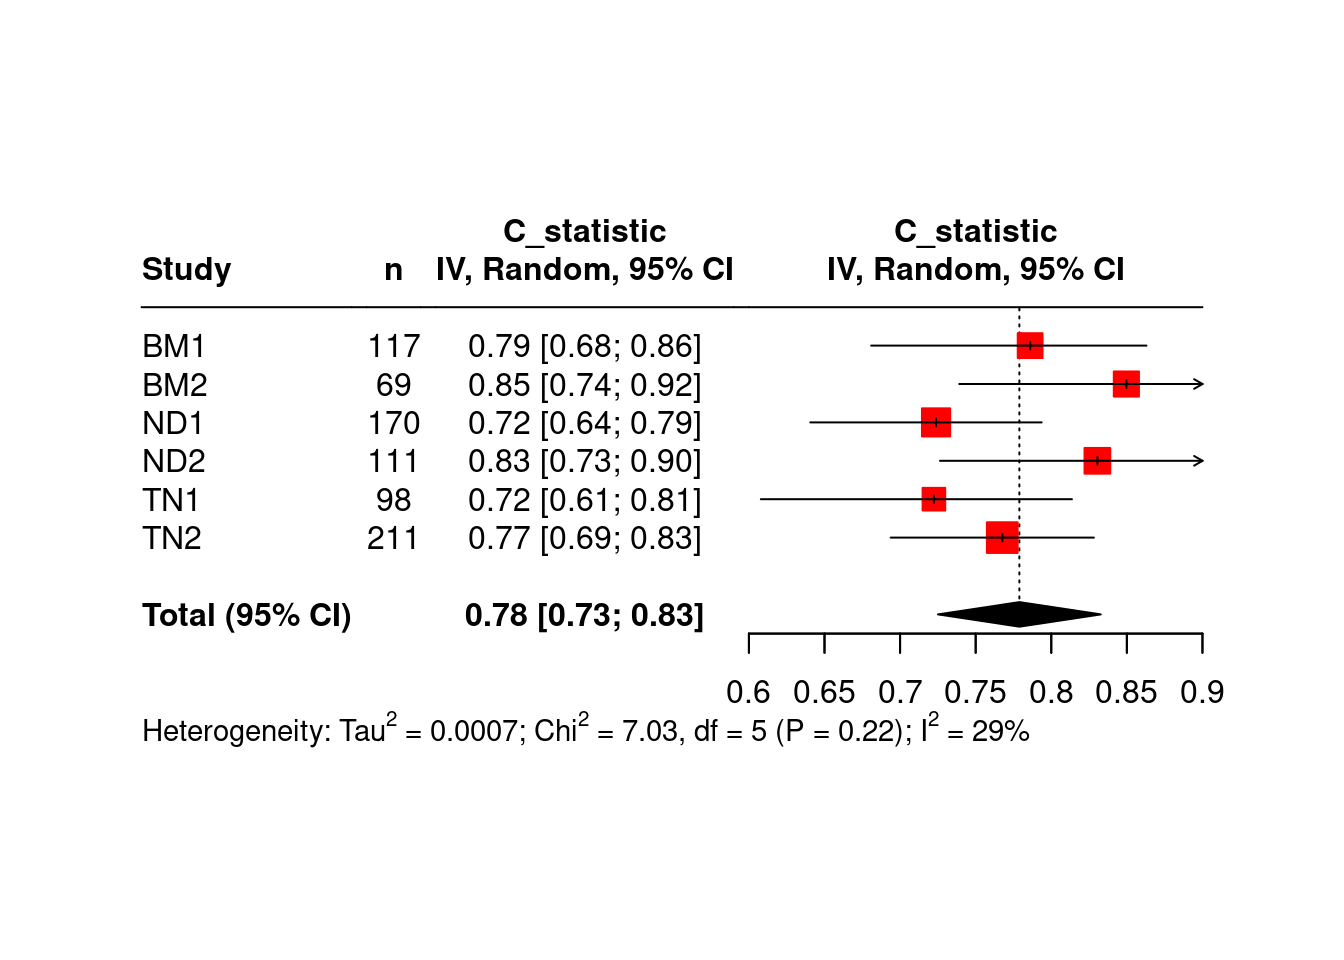

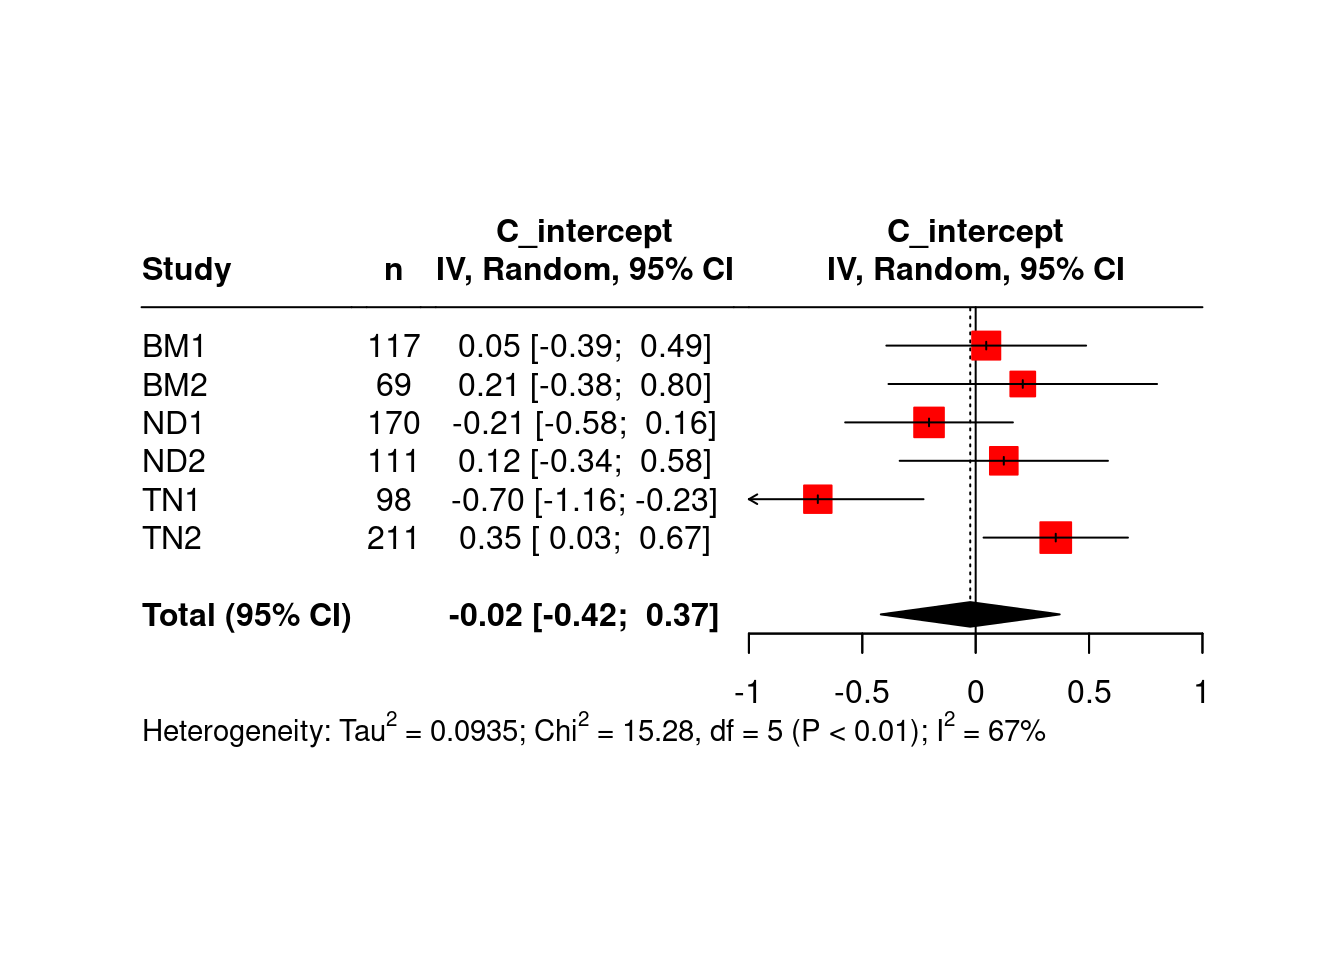

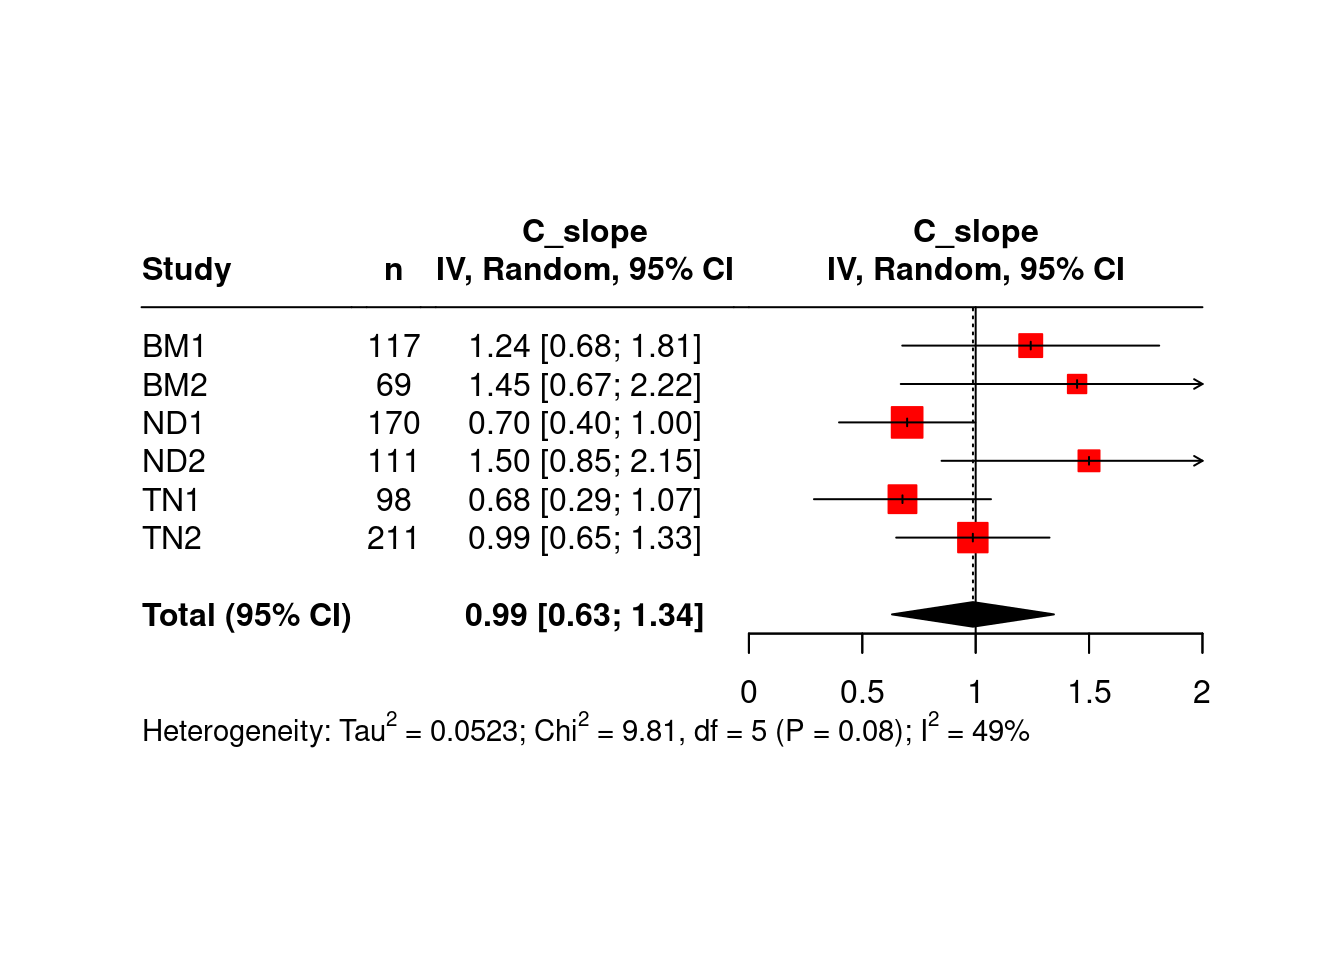

In [ ]:
library(meta)

cross_C_index_meta_BMA <- metagen(
  data = cross_estimates_BMA,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BMA <- forest(
  cross_C_index_meta_BMA,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  leftcols = c("studlab", "n", "effect.ci"),
  addrows.below.overall = 2,
  layout = "RevMan5"
)

In [ ]:
save(cross_performance_metrics_BMA, file = "data/model-performance/cross-performance-metrics-BMA.rda")

# Logistic Model 2_A

In [ ]:
library(rsample) # for group_vfold_cv()
library(furrr) # for future_map()
library(tidymodels)
library(CalibrationCurves)
library(calibrationHelper)

data_patient_cross_prep_2_A <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID, site, patient_ID)

cross_samples_2_A <- group_vfold_cv(data_patient_cross_prep_2_A, group = "site")

extract_variable_names_cross_2_A <- function(sample) {
  data <- analysis(sample)
  model <- data |>
    run_bas_glm(
      formula = reformulate(termlabels = variables_to_screen, response = "flag_ADR_TP_ID"),
      include.always = ~1,
      n.models = 2^15,
      thin = length(variables_to_screen),
      method = "MCMC+BAS",
      update = 2^10
    )
  top_index <- which(cumsum(model$postprobs |> sort(decreasing = TRUE)) >= 0.5)[1]
  # model_HPM <- variable.names(predict(model, estimator = "HPM"))[-1] |>
  #   str_extract(paste(variables_to_screen, collapse = "|"))
  model_BPM <- variable.names(predict(model, estimator = "BPM", top = top_index))[-1] |>
    str_extract(paste(variables_to_screen, collapse = "|"))
  site <- assessment(sample)$site[1]
  return(list(model_BPM, site, model))
}

plan(multisession, workers = max(min(parallel::detectCores() - 1, 6), 2))

cross_predict_2_A <- future_map(cross_samples_2_A$splits, extract_variable_names_cross_2_A, .options = furrr_options(seed = TRUE))

plan(sequential)

cross_predict_BPM_2_A <- map(cross_predict_2_A, 1)
cross_predict_site_2_A <- map(cross_predict_2_A, 2)
cross_black_box_2_A <- map(cross_predict_2_A, 3)

run_workflow <- function(sample, variables) {
  rec <- recipe(
    formula <- reformulate(termlabels = variables, response = "flag_ADR_TP_ID"),
    data = analysis(sample) |> mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID))
  )
  trained <- workflow() |>
    add_recipe(rec) |>
    add_model(logistic_reg()) |>
    fit(data = analysis(sample) |> mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID)))
  validation <- predict(trained, assessment(sample), type = "prob") |>
    mutate(
      truth = assessment(sample)$flag_ADR_TP_ID |> as.factor(),
      patient_ID = assessment(sample)$patient_ID,
      site = assessment(sample)$site
    )

  auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
  intercept <- cal_intercept(validation, truth, .pred_FALSE)
  slope <- cal_slope(validation, truth, .pred_FALSE) |> mutate(.estimate = .estimate + 1) # workaround for issue with cal_slope()

  performance <- bind_rows(auc, intercept, slope) |>
    select(-.estimator) |>
    pivot_wider(names_from = .metric, values_from = .estimate) |>
    mutate(site = assessment(sample)$site[1])

  list(predictions = validation, performance = performance)
}

workflow_results_2_A <- map2(cross_samples_2_A$splits, cross_predict_BPM_2_A, run_workflow)
predictions_full_2_A <- map(workflow_results_2_A, "predictions") |> bind_rows()
performance_full_2_A <- map(workflow_results_2_A, "performance") |> bind_rows()

In [ ]:
# Function to modify sample data and fit model
fit_model_to_sample <- function(sample, variables) {
  data <- analysis(sample) |>
    mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID))

  formula <- reformulate(termlabels = variables, response = "flag_ADR_TP_ID")

  logistic_reg() |>
    set_engine("glm") |>
    set_mode("classification") |>
    fit(formula, data = data)
}

calc_cross_performance <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model$fit, data, type = "response")
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, smooth = "none")

  tibble(
    site = data$site[1],
    n = nrow(data),
    cross_C_index = calperf$Cindex[[1]],
    cross_C_index_lower = calperf$Cindex[[2]],
    cross_C_index_upper = calperf$Cindex[[3]],
    cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
    cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
    cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
    cross_calibration_slope = calperf$Calibration$Slope[[1]],
    cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
    cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
  )
}

plot_calibration_curve <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model$fit, data, type = "response")
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
  calperf$ggPlot + ggtitle(data$site[1])
}

# Fit model to each sample
cross_full_BPM_2_A <- map2(cross_samples_2_A$splits, cross_predict_BPM_2_A, fit_model_to_sample)

cross_estimates_BPM_2_A <- map2_dfr(cross_samples_2_A$splits, cross_full_BPM_2_A, calc_cross_performance)

cross_plots_BPM_2_A <- map2(cross_samples_2_A$splits, cross_full_BPM_2_A, plot_calibration_curve)

[[1]]

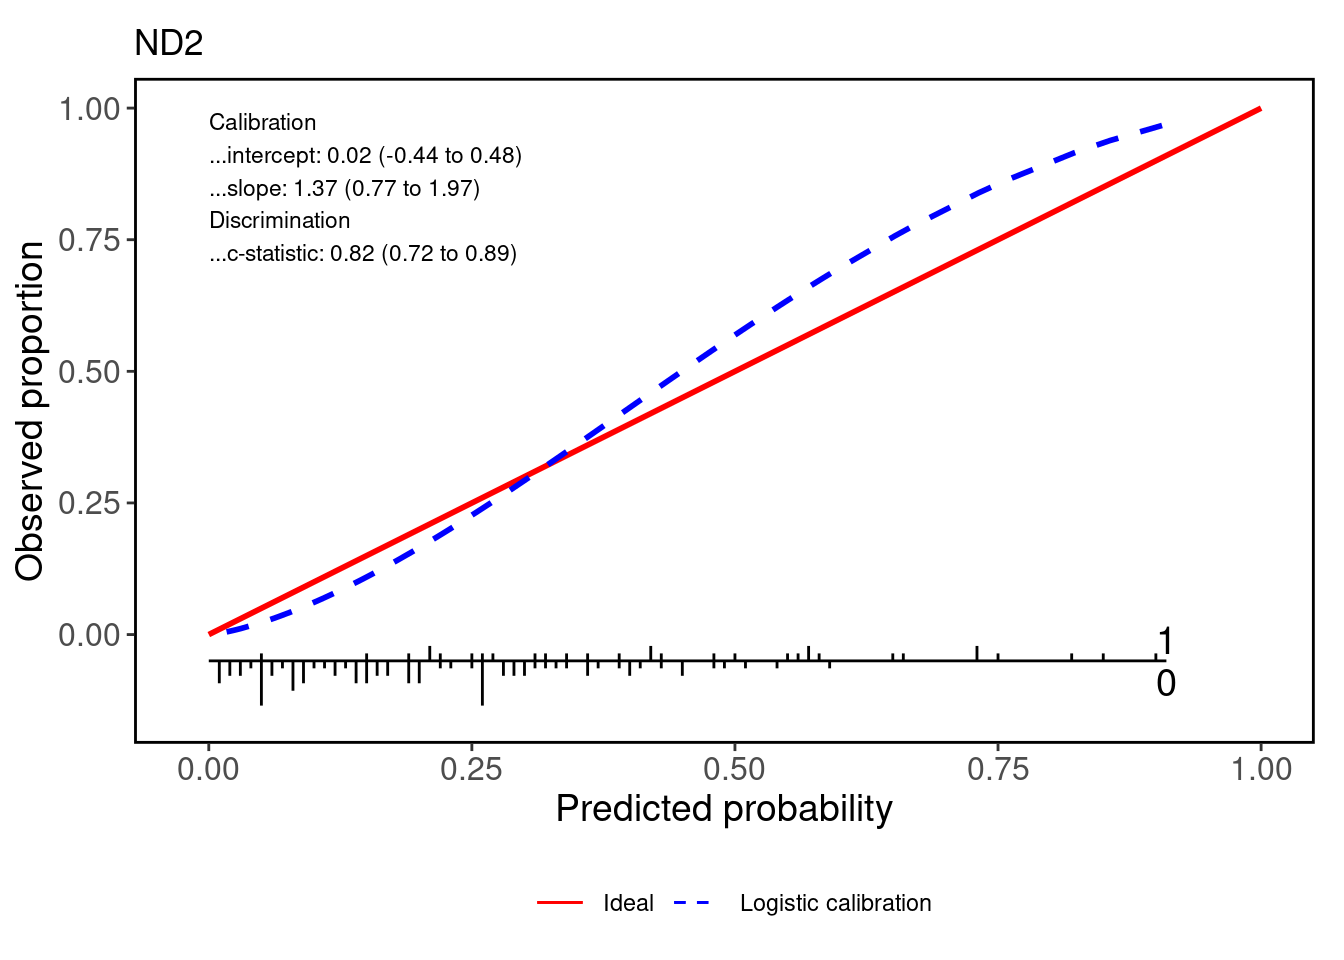


[[2]]

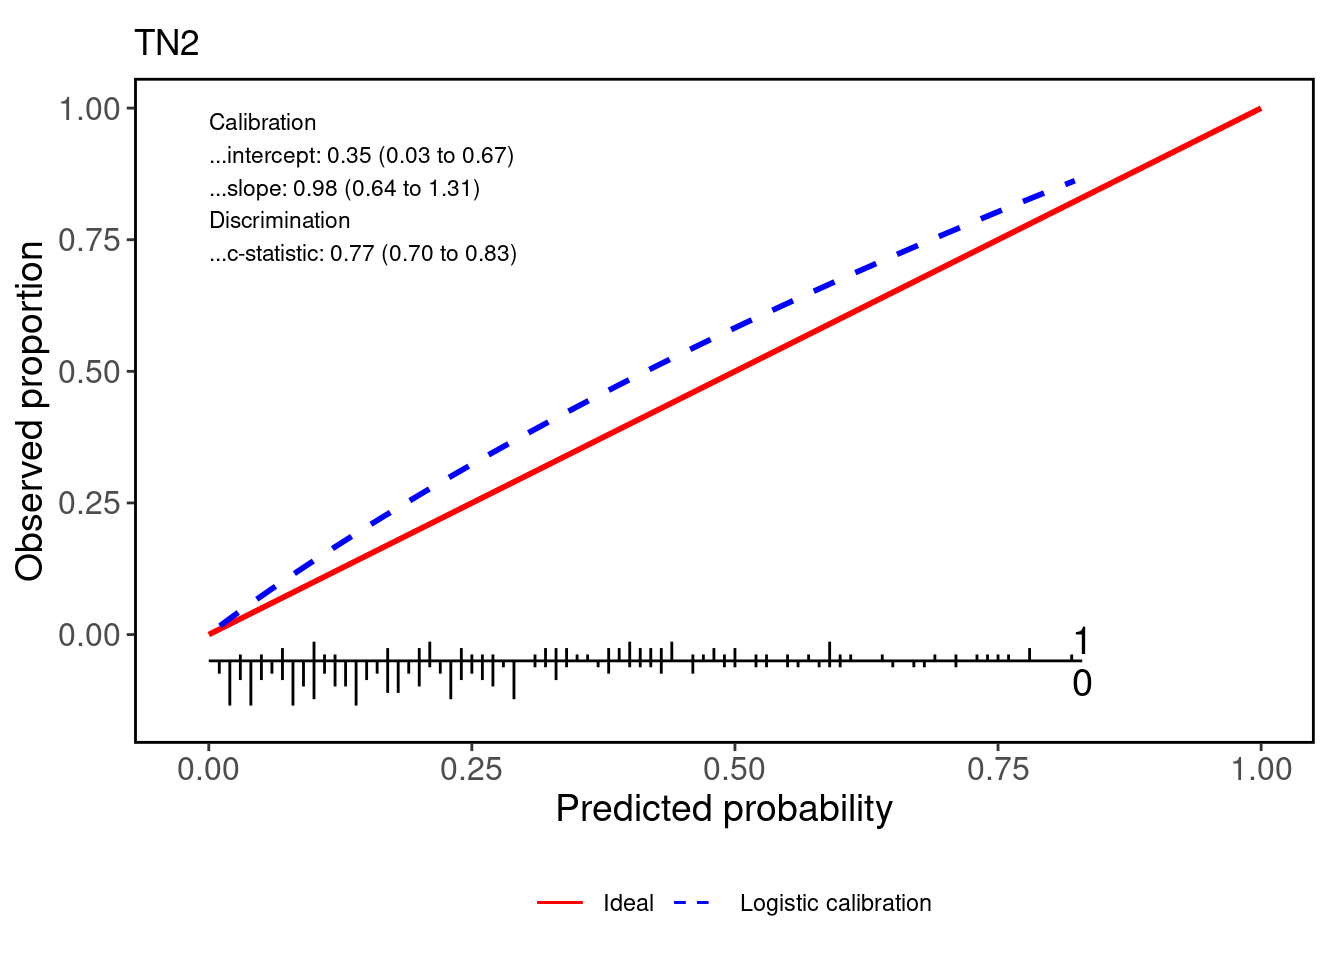


[[3]]

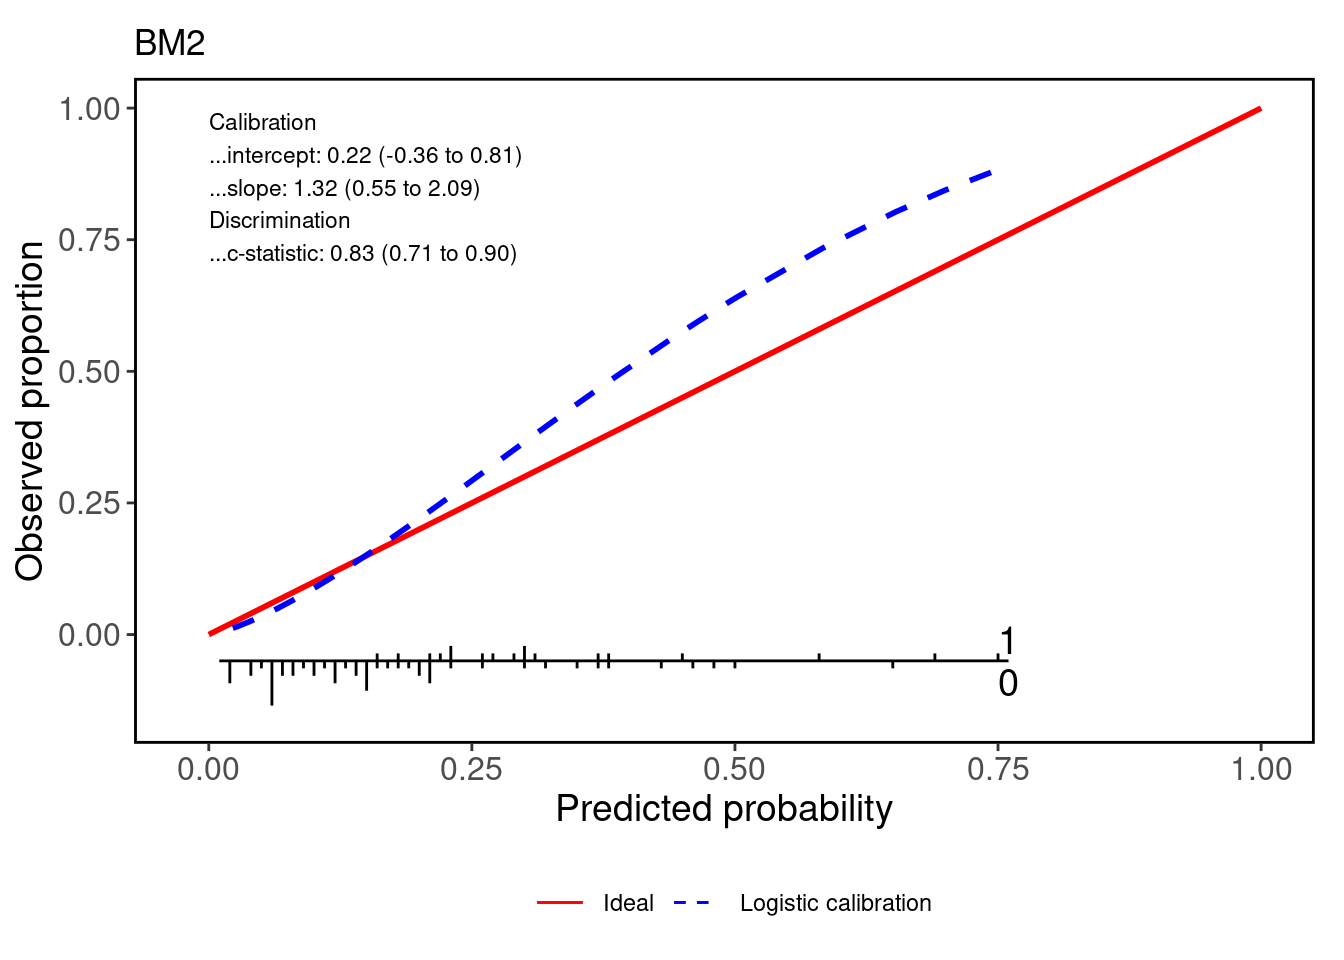


[[4]]

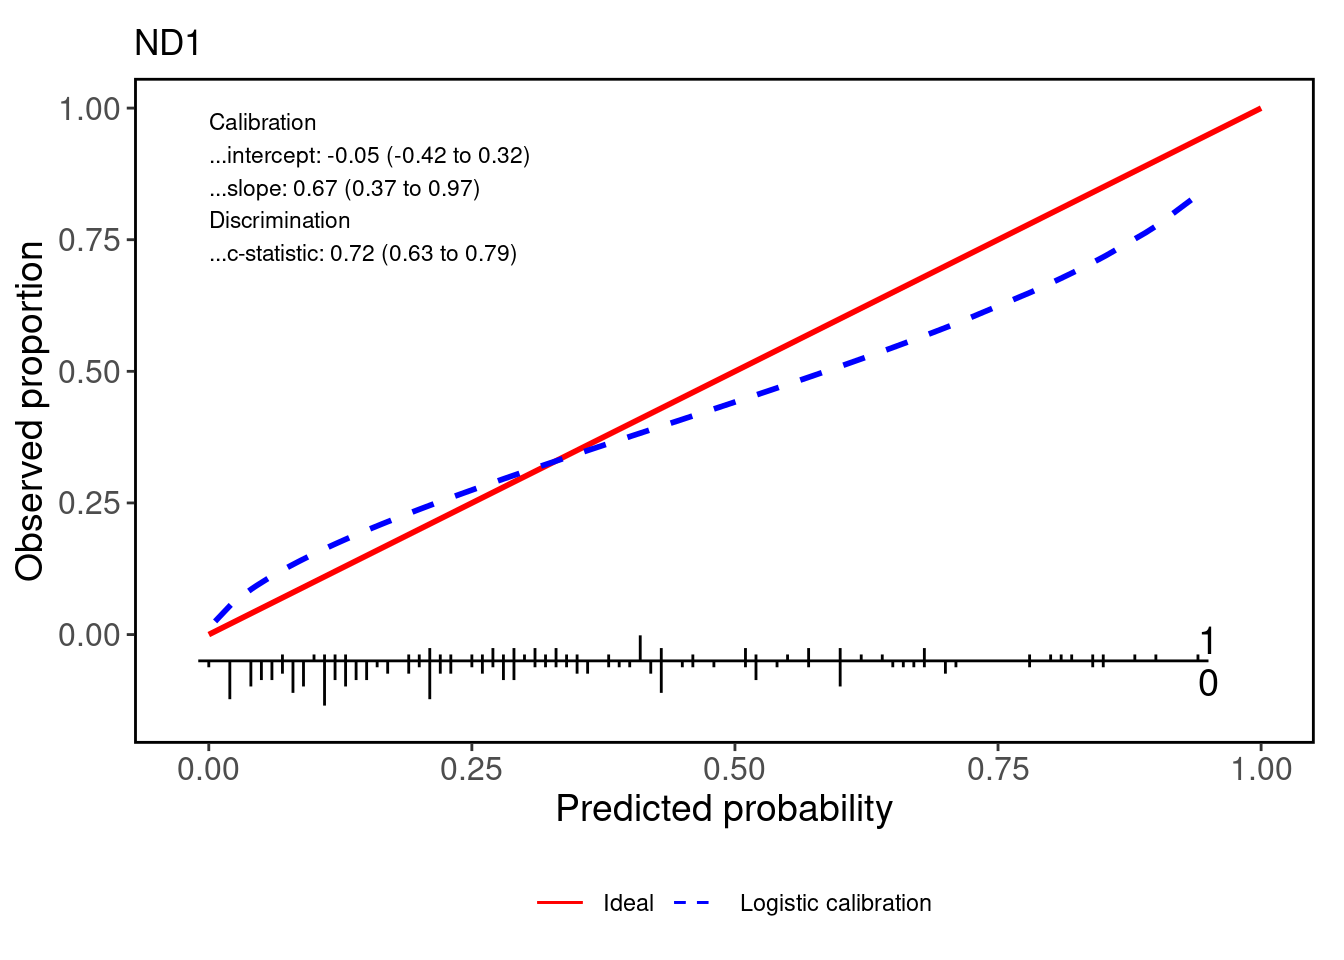


[[5]]

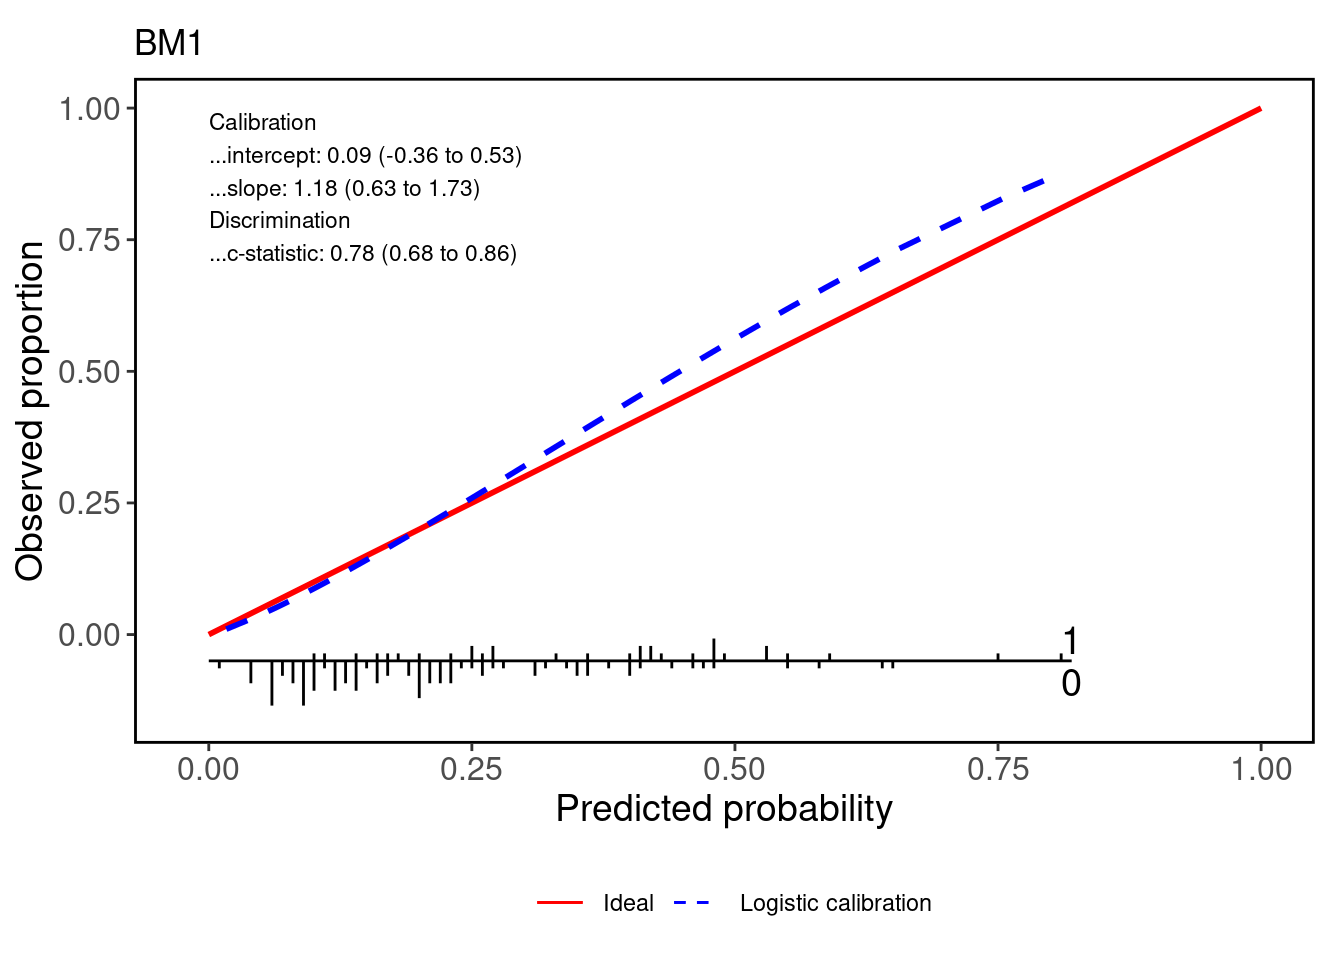


[[6]]

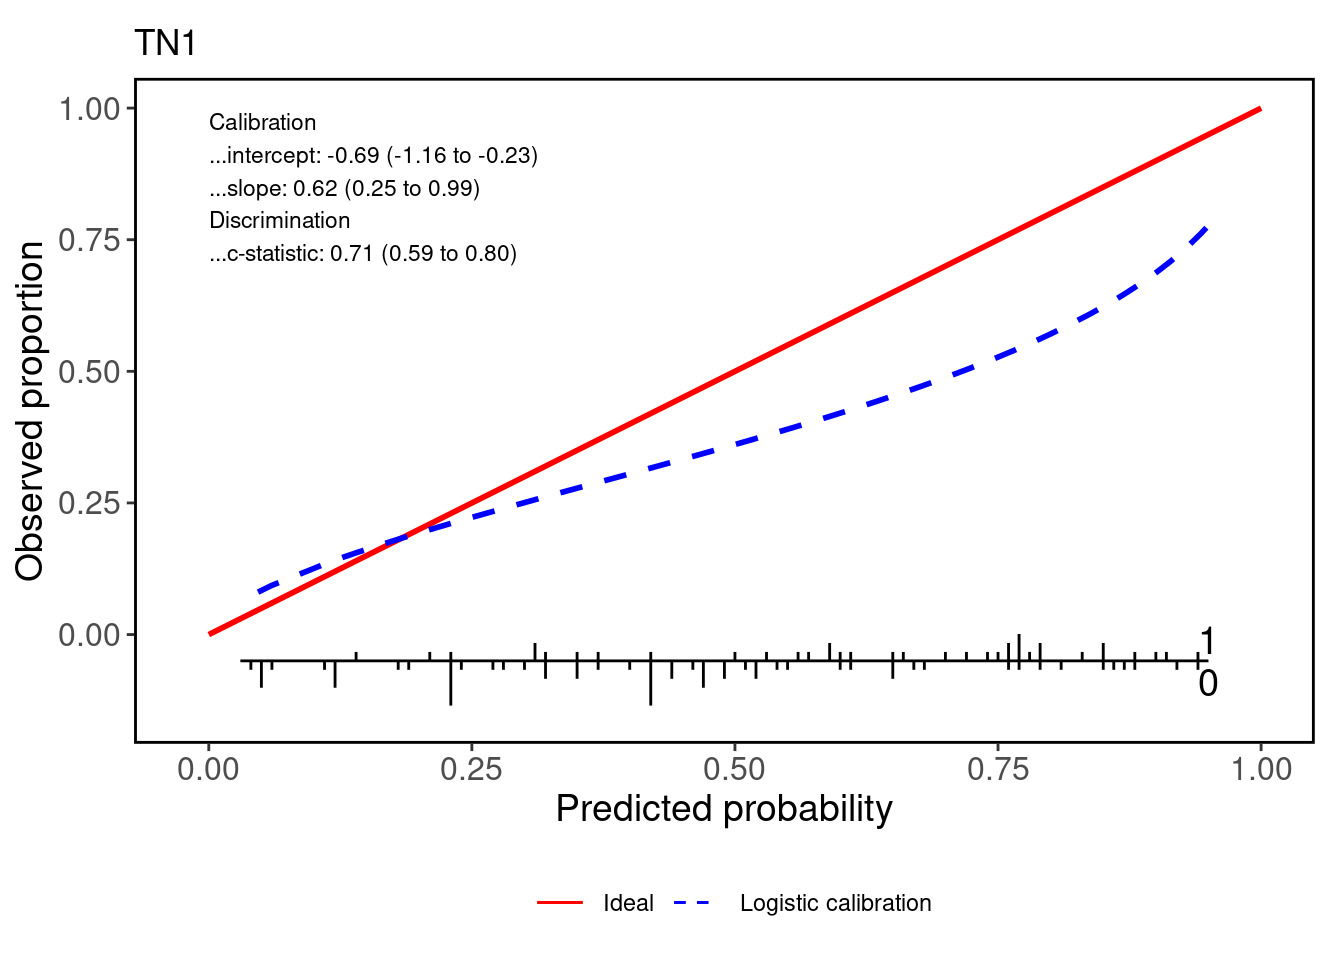

In [ ]:
cross_plots_BPM_2_A

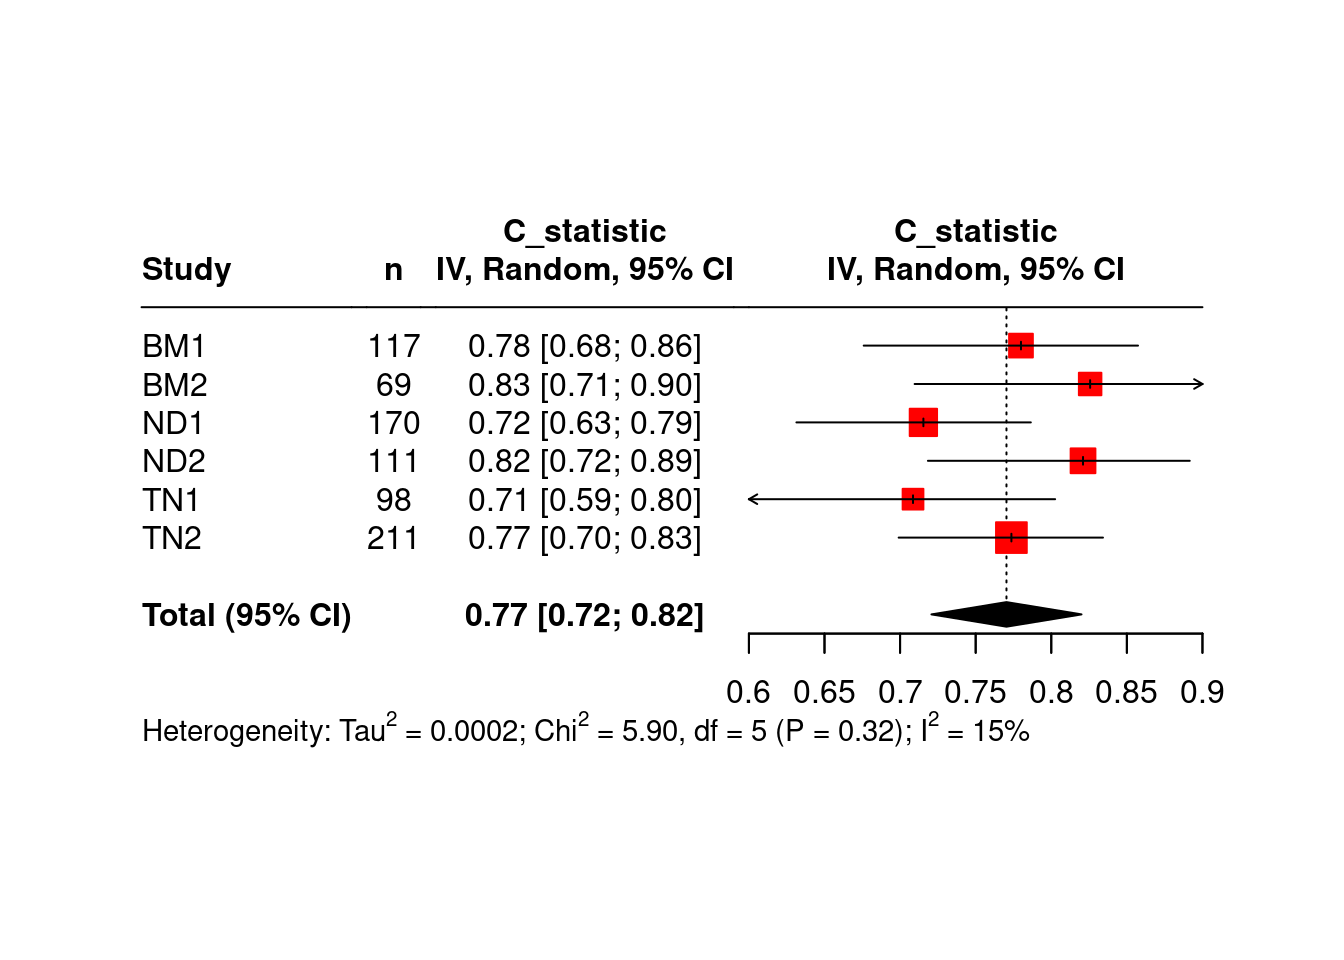

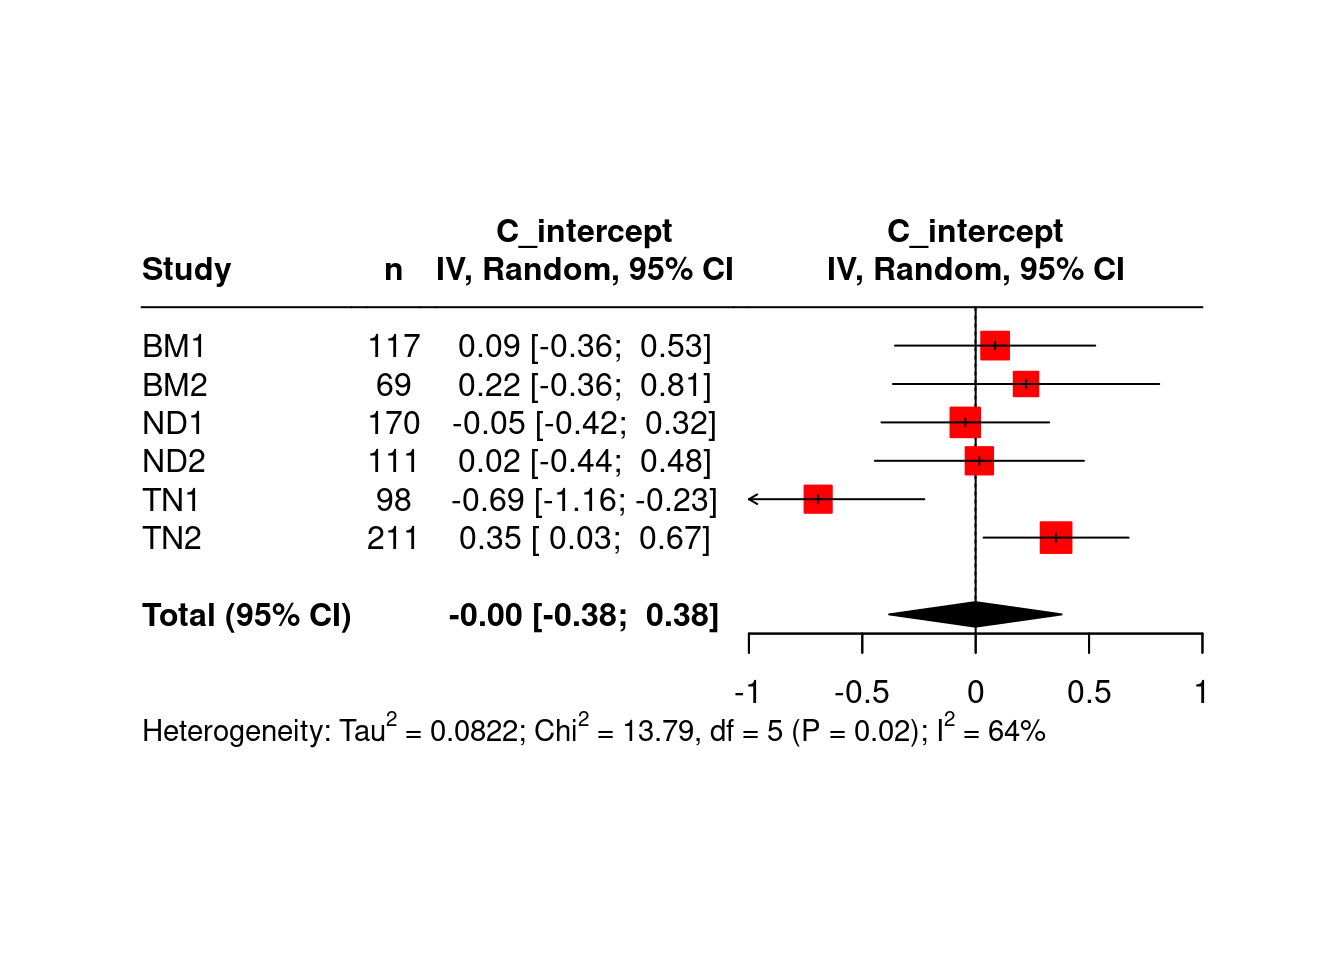

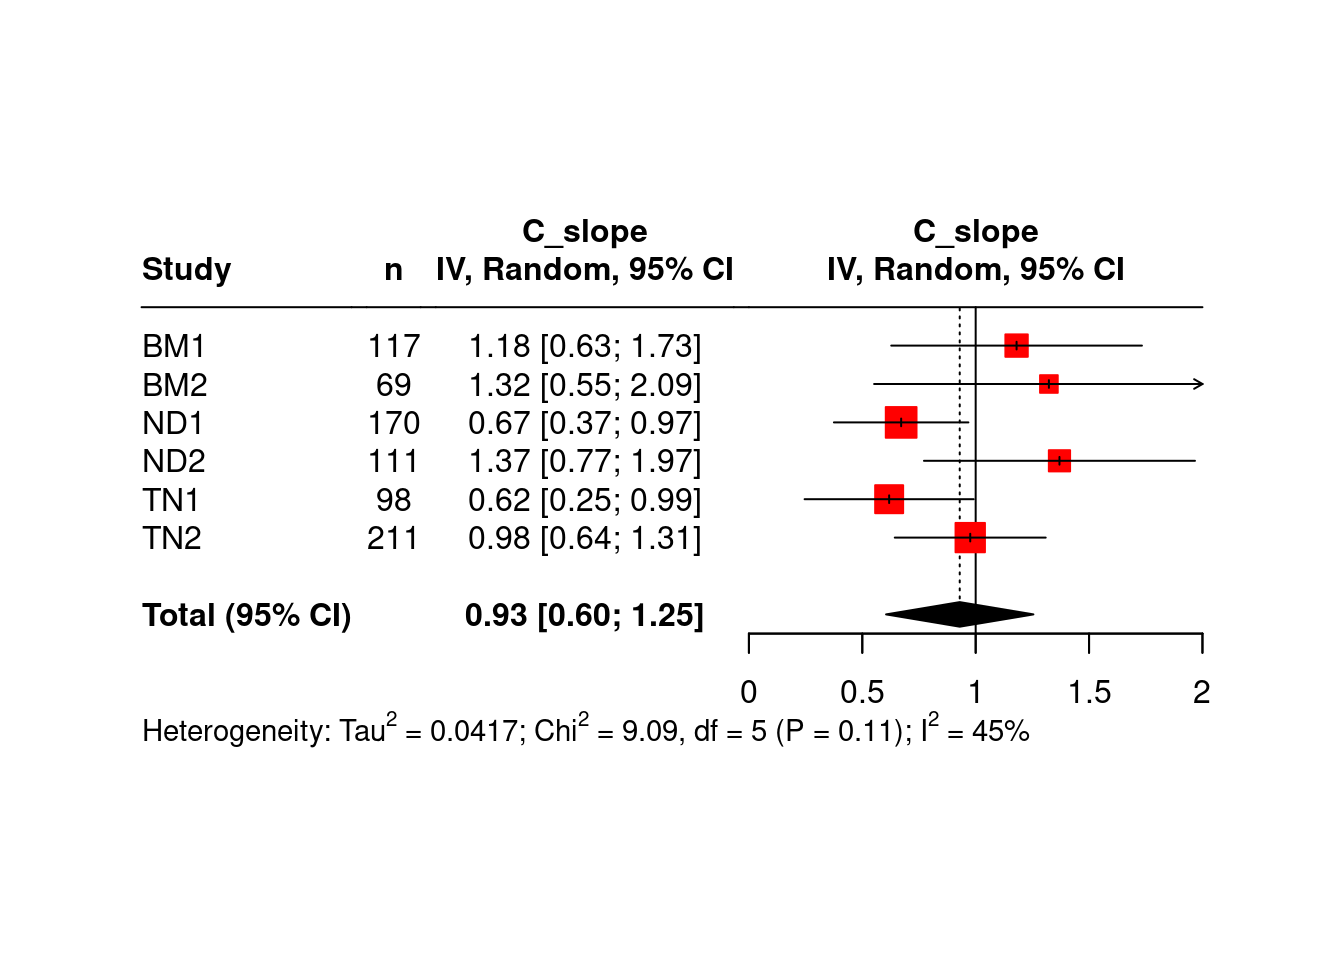

In [ ]:
library(meta)

cross_C_index_meta_BPM_2_A <- metagen(
  data = cross_estimates_BPM_2_A,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BPM_2_A <- forest(
  cross_C_index_meta_BPM_2_A,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  leftcols = c("studlab", "n", "effect.ci"),
  addrows.below.overall = 2,
  layout = "RevMan5"
)

In [ ]:
# save(cross_performance_metrics_HPM, file = "data/model-performance/cross-performance-metrics-HPM.rda")
save(cross_performance_metrics_BPM_2_A, file = "data/model-performance/cross-performance-metrics-BPM_2_A.rda")

# BMA Black Box (21 variables)

[[1]]

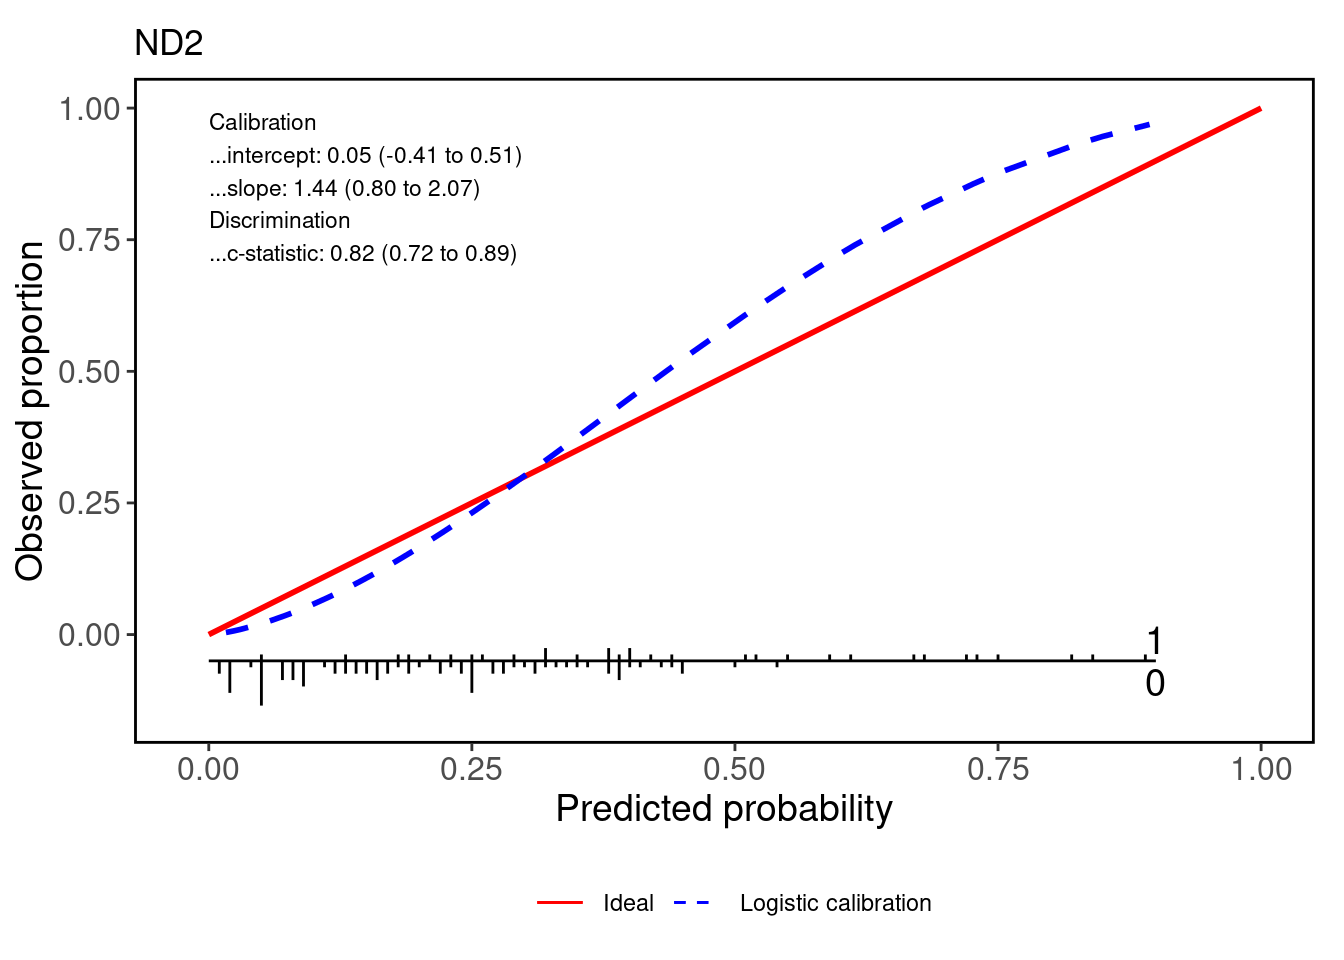


[[2]]

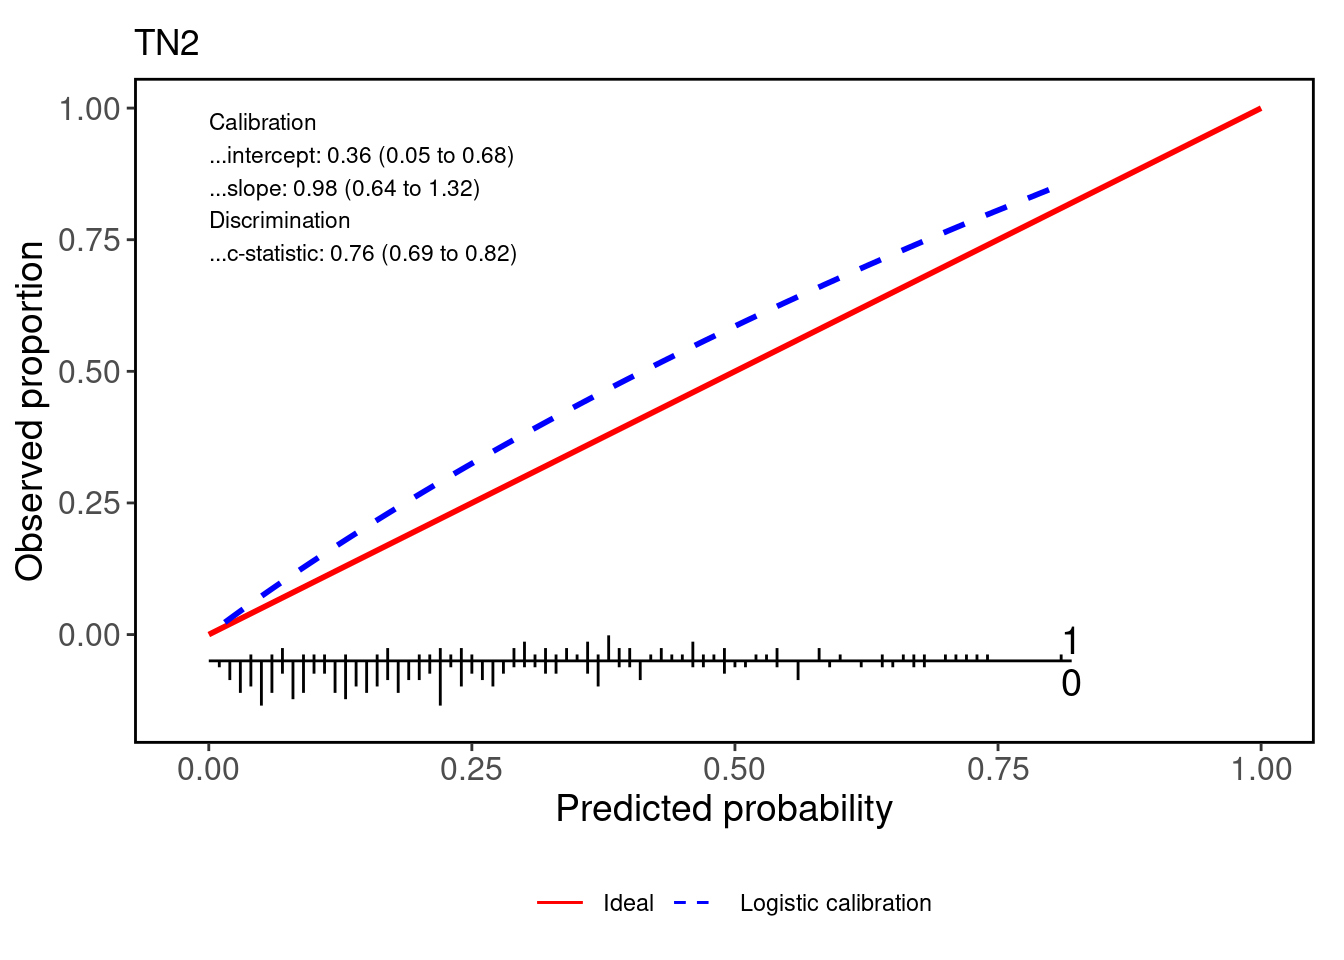


[[3]]

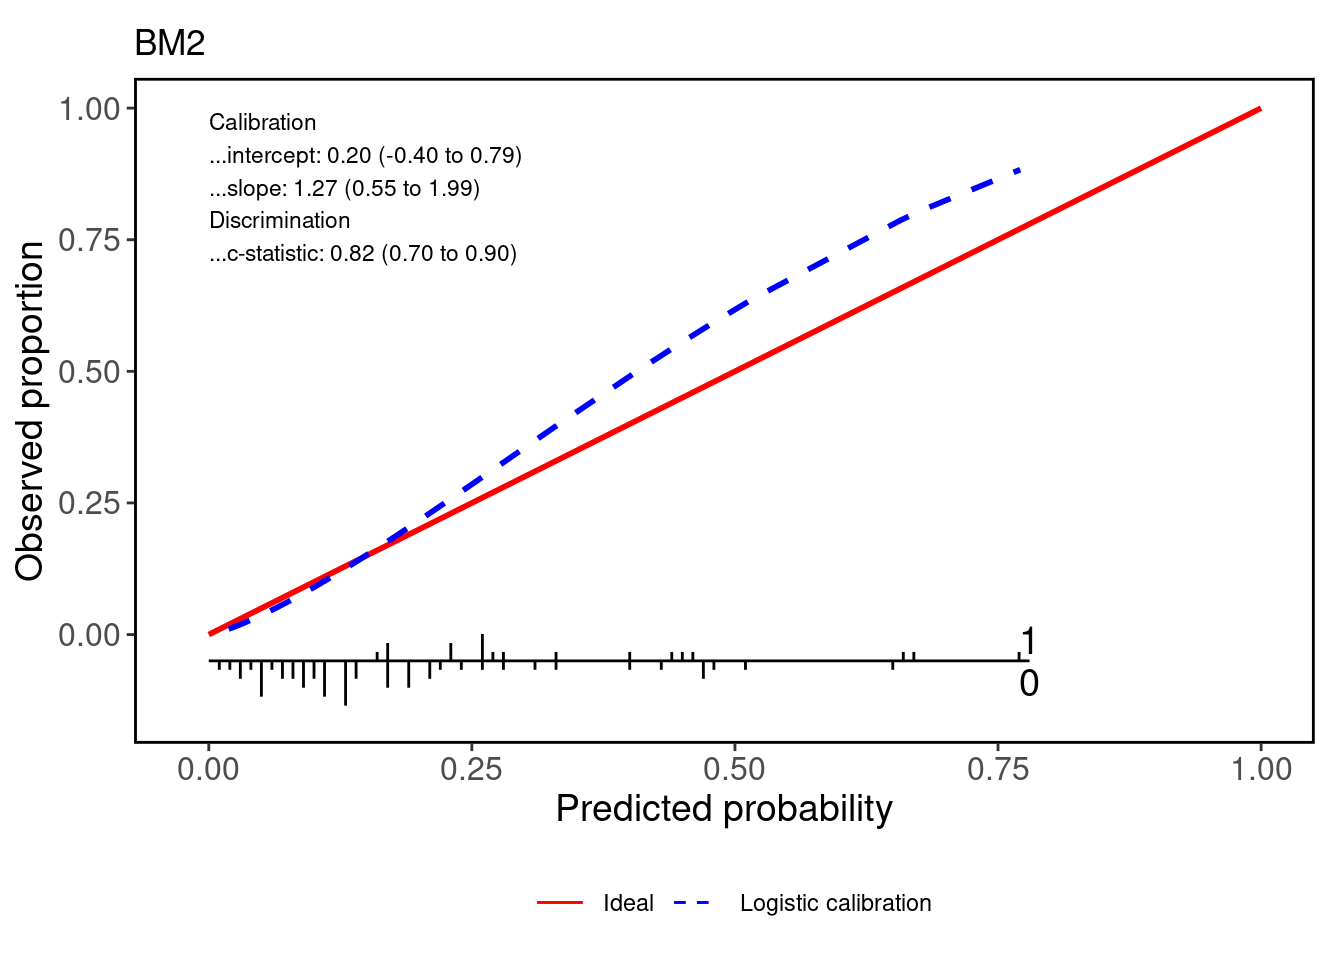


[[4]]

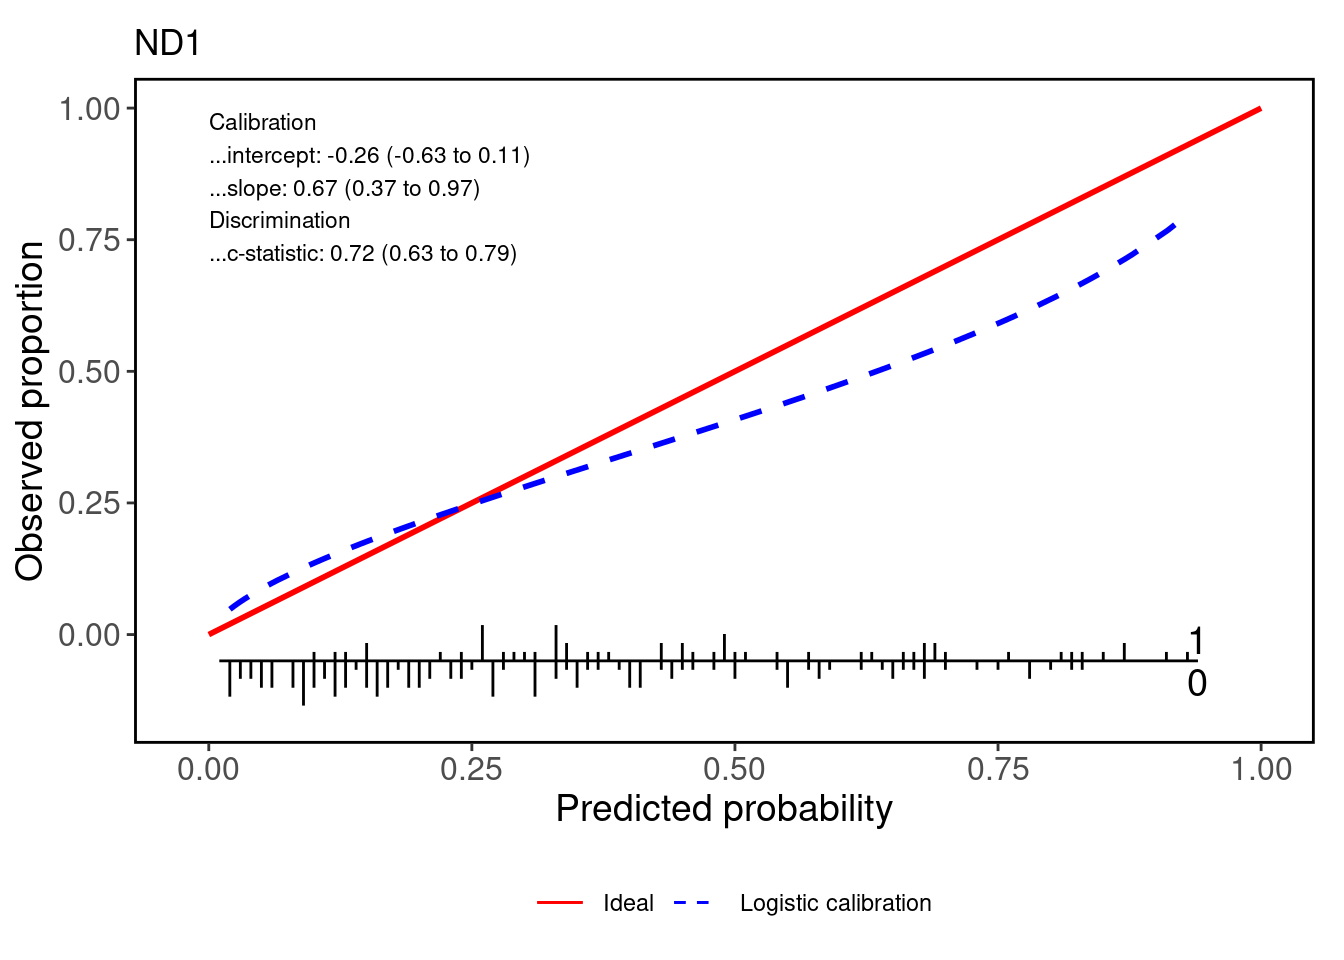


[[5]]

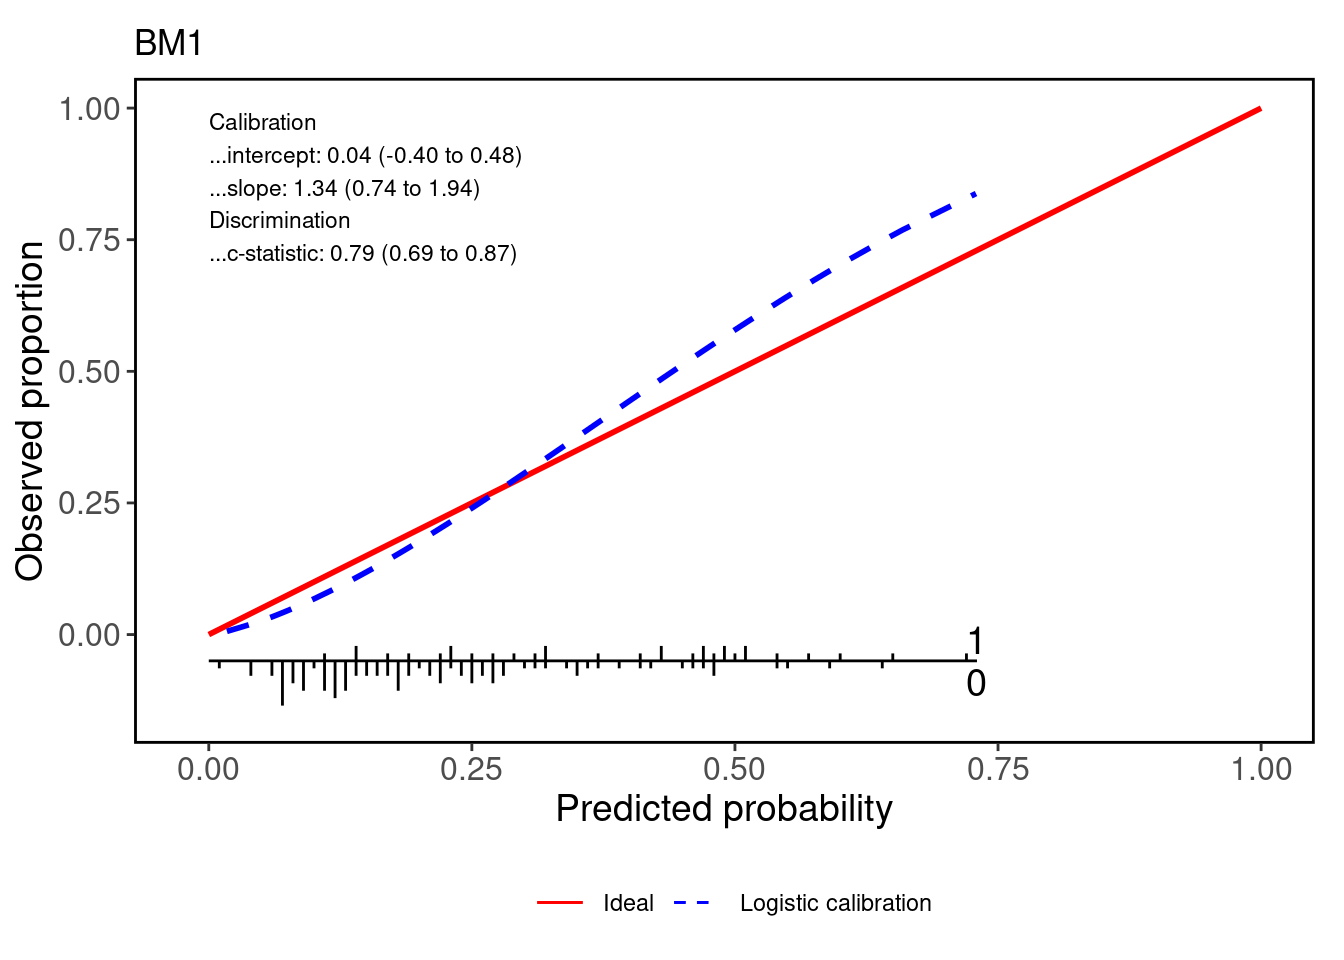


[[6]]

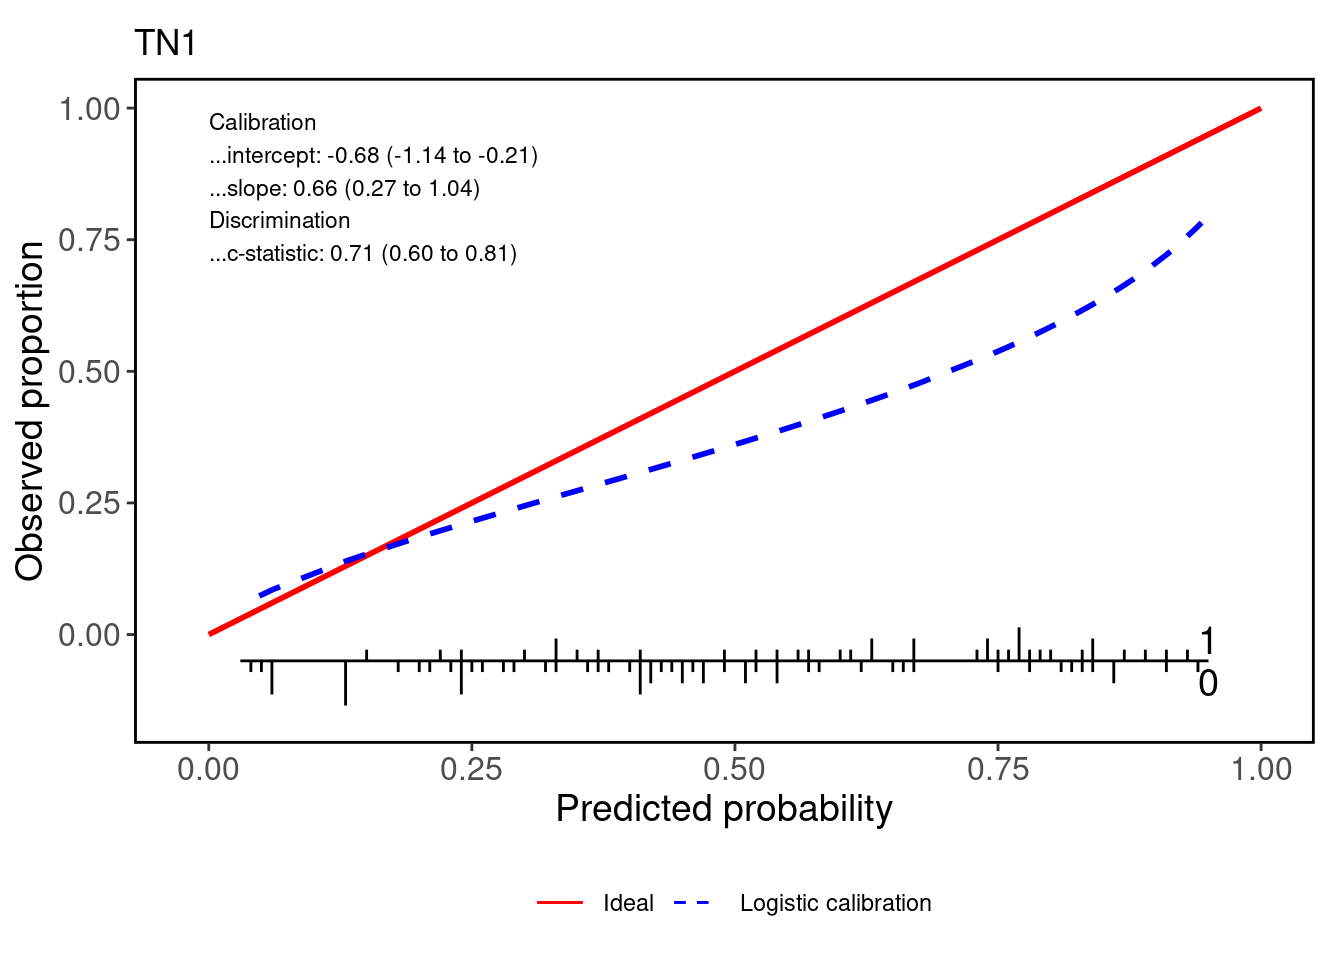

In [ ]:
run_workflow_black_box <- function(sample, model) {
  validation <- predict(model, newdata = assessment(sample), type = "response") |>
    _$fit |>
    as_tibble() |>
    rename(.pred_TRUE = value) |>
    mutate(
      .pred_FALSE = 1 - .pred_TRUE,
      truth = assessment(sample)$flag_ADR_TP_ID |> as.factor()
    ) |>
    relocate(.pred_FALSE)

  auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
  intercept <- cal_intercept(validation, truth, .pred_FALSE)
  slope <- cal_slope(validation, truth, .pred_FALSE)
  bind_rows(auc, intercept, slope)
}

workflow_results_BMA_2_A <- map2(cross_samples_2_A$splits, cross_black_box_2_A, run_workflow_black_box) |>
  set_names(cross_predict_site_2_A) |>
  bind_rows(.id = "site") |>
  select(-.estimator) |>
  pivot_wider(names_from = .metric, values_from = .estimate)

calc_cross_performance_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, smooth = "none")

  tibble(
    site = data$site[1],
    n = nrow(data),
    cross_C_index = calperf$Cindex[[1]],
    cross_C_index_lower = calperf$Cindex[[2]],
    cross_C_index_upper = calperf$Cindex[[3]],
    cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
    cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
    cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
    cross_calibration_slope = calperf$Calibration$Slope[[1]],
    cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
    cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
  )
}

cross_estimates_BMA_2_A <- map2_dfr(cross_samples_2_A$splits, cross_black_box_2_A, calc_cross_performance_black_box)

plot_calibration_curve_black_box <- function(sample, model) {
  data <- assessment(sample)
  pHat <- predict(model, data, type = "response") |> _$fit
  yTest <- data$flag_ADR_TP_ID
  calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
  calperf$ggPlot + ggtitle(data$site[1])
}

cross_plots_BMA_2_A <- map2(cross_samples_2_A$splits, cross_black_box_2_A, plot_calibration_curve_black_box)

cross_plots_BMA_2_A

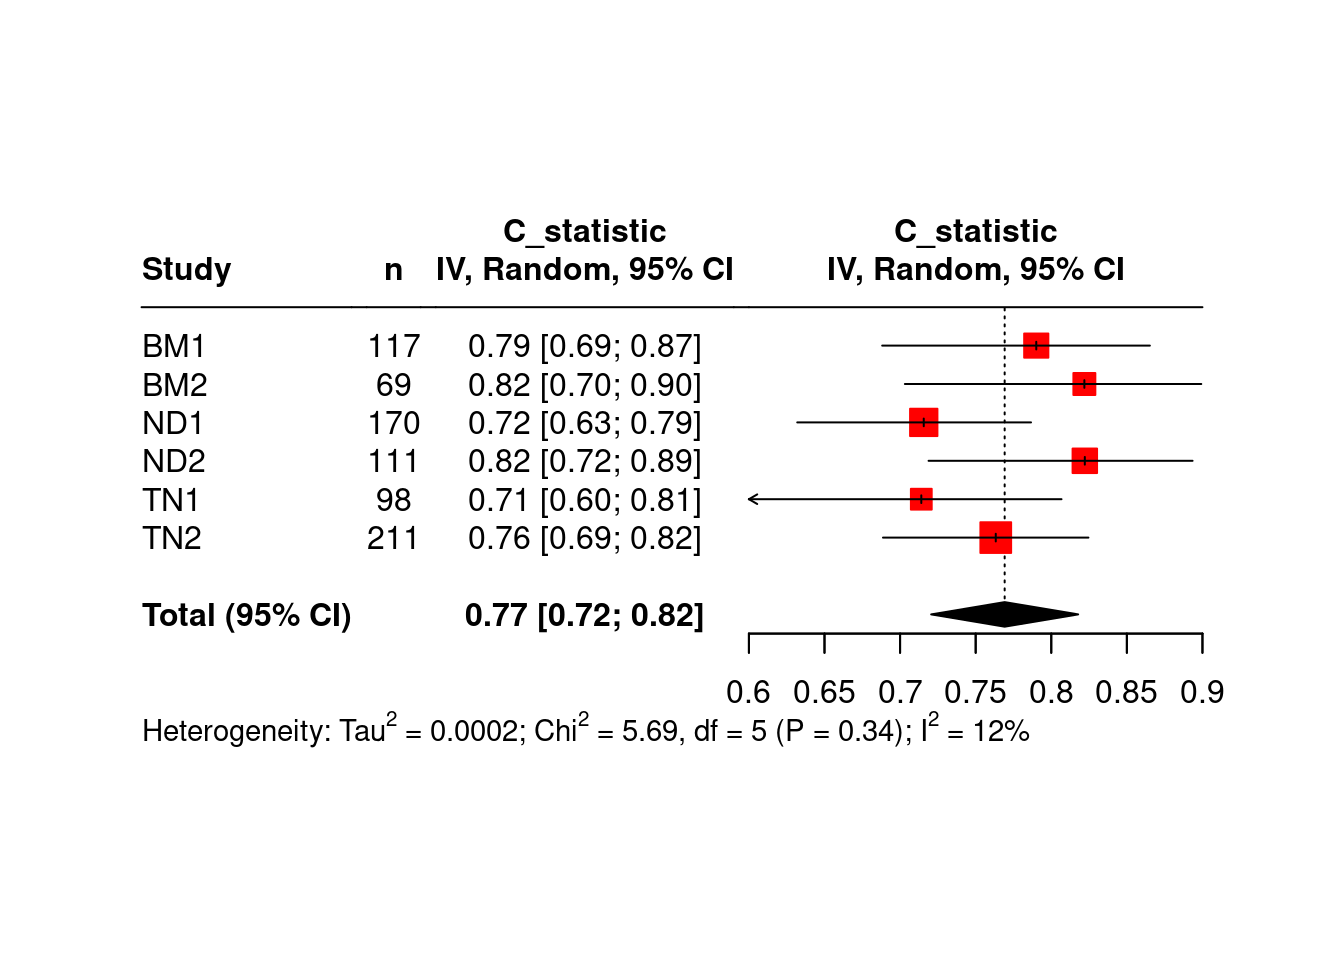

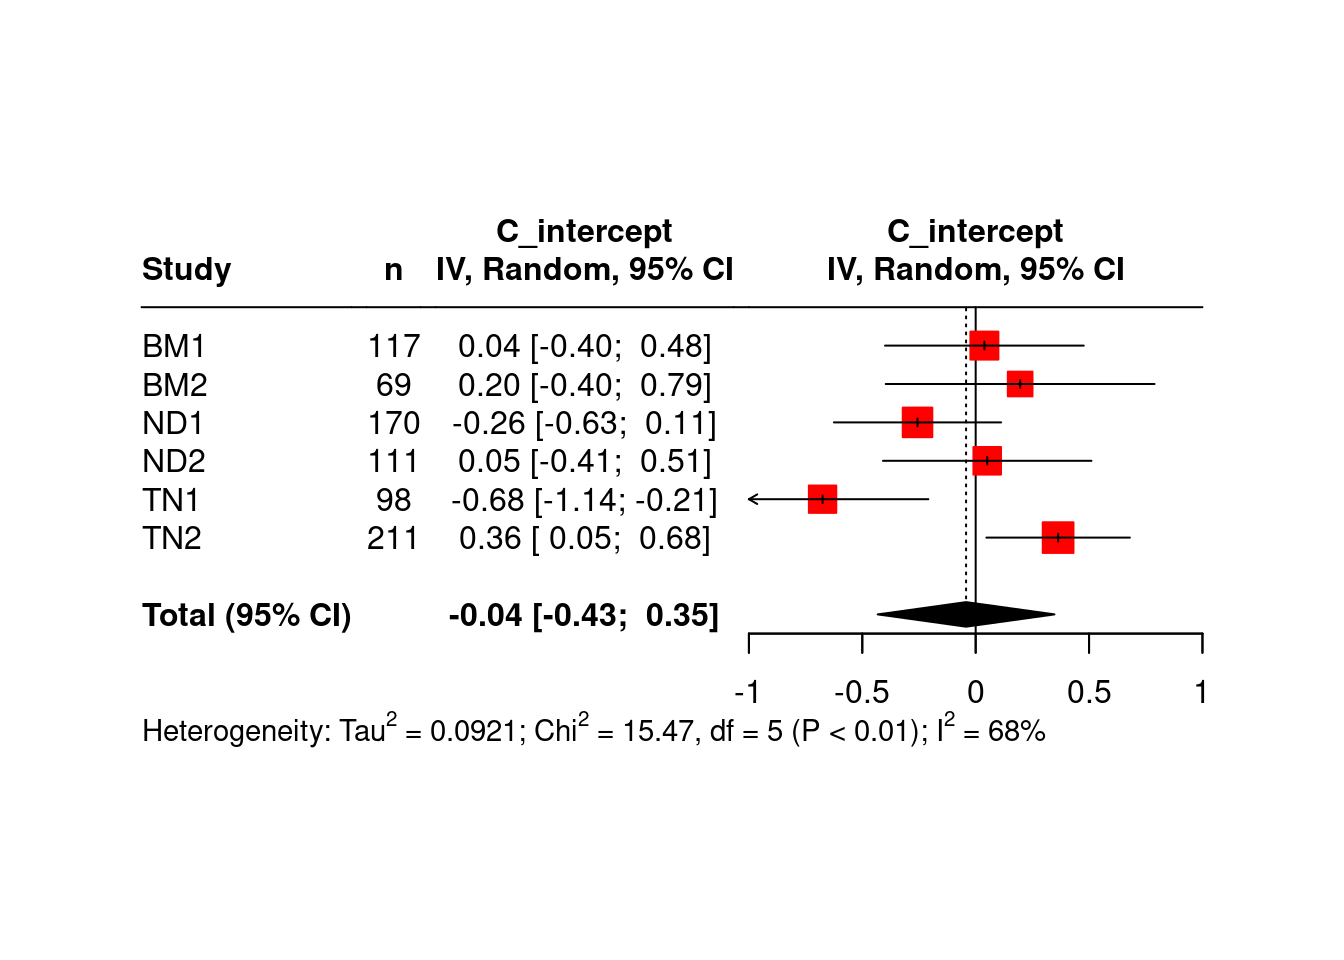

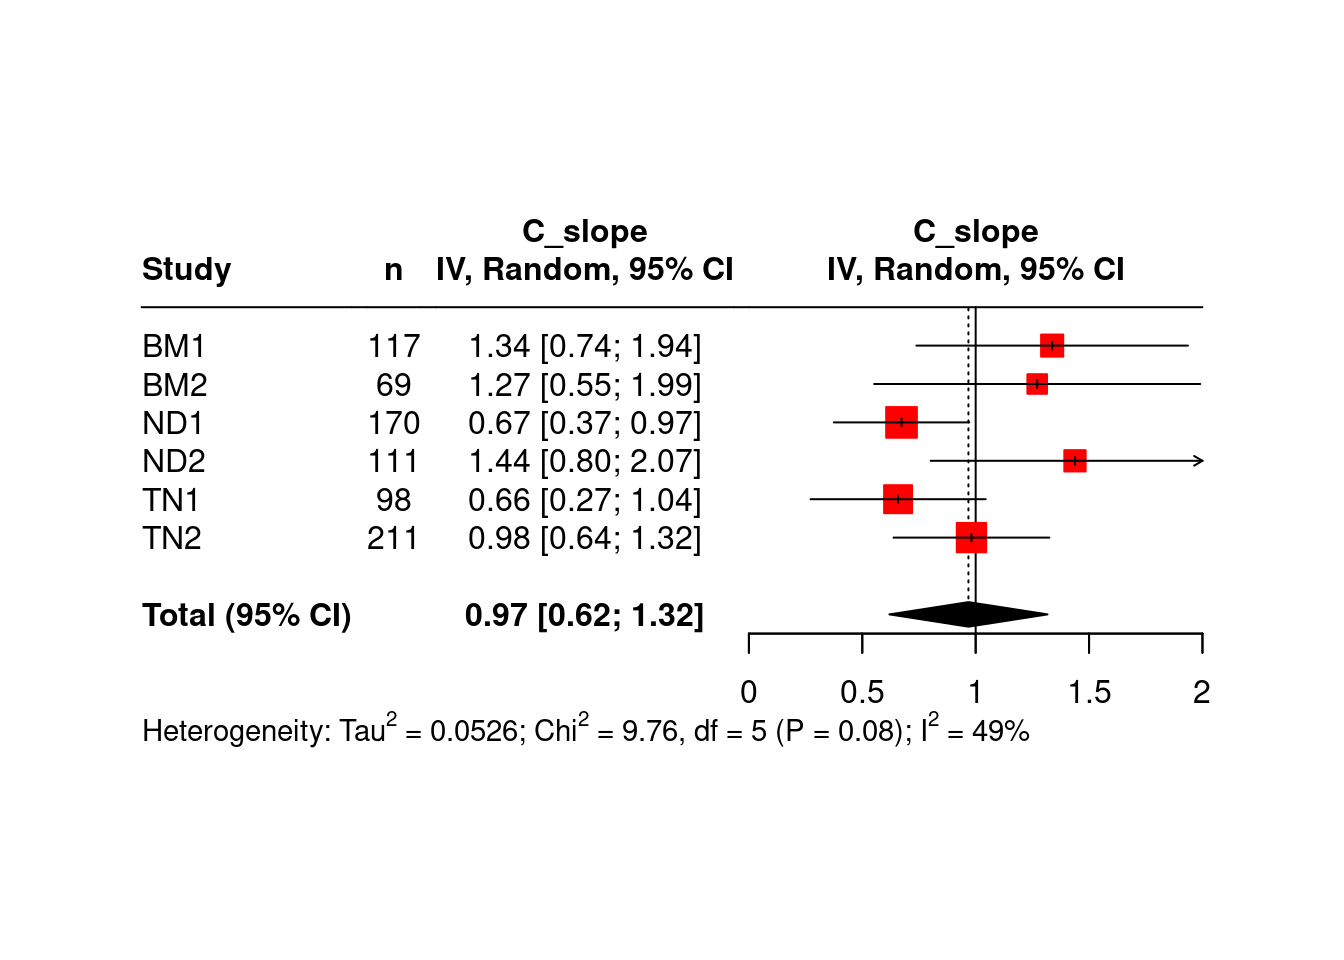

In [ ]:
library(meta)

cross_C_index_meta_BMA_2_A <- metagen(
  data = cross_estimates_BMA_2_A,
  studlab = site,
  TE = cross_C_index,
  lower = cross_C_index_lower,
  upper = cross_C_index_upper,
  sm = "C_statistic",
  common = FALSE,
  random = TRUE,
  method.tau = "REML",
  method.random.ci = "HK",
  adhoc.hakn.ci = "IQWiG6",
)

forest_plot_C_index_BMA_2_A <- forest(
  cross_C_index_meta_BMA_2_A,
  sortvar = studlab,
  ref = NA,
  xlim = c(0.6, 0.9),
  leftcols = c("studlab", "n", "effect.ci"),
  addrows.below.overall = 2,
  layout = "RevMan5"
)

In [ ]:
save(cross_performance_metrics_BMA_2_A, file = "data/model-performance/cross-performance-metrics-BMA_2_A.rda")

# Logistic Model 3_A

In [ ]:
# library(rsample) # for group_vfold_cv()
# library(furrr) # for future_map()
# library(tidymodels)
# library(CalibrationCurves)
# library(calibrationHelper)

# data_patient_cross_prep_3_A <- data_patient_transformed |>
#   select(any_of(variables_to_screen_all), flag_ADR_TP_ID, site, patient_ID)

# cross_samples_3_A <- group_vfold_cv(data_patient_cross_prep_3_A, group = "site")

# extract_variable_names_cross_3_A <- function(sample) {
#   data <- analysis(sample)
#   model <- data |>
#     run_bas_glm(
#       formula = reformulate(termlabels = variables_to_screen_all, response = "flag_ADR_TP_ID"),
#       include.always = ~1,
#       n.models = 2^16,
#       thin = length(variables_to_screen_all),
#       method = "MCMC+BAS",
#       update = 2^11
#     )
#   top_index <- which(cumsum(model$postprobs |> sort(decreasing = TRUE)) >= 0.5)[1]
#   # model_HPM <- variable.names(predict(model, estimator = "HPM"))[-1] |>
#   #   str_extract(paste(variables_to_screen, collapse = "|"))
#   model_BPM <- variable.names(predict(model, estimator = "BPM", top = top_index))[-1] |>
#     str_extract(paste(variables_to_screen_all, collapse = "|"))
#   site <- assessment(sample)$site[1]
#   return(list(model_BPM, site, model))
# }

# plan(multisession, workers = max(min(parallel::detectCores() - 1, 6), 2))

# cross_predict_3_A <- future_map(cross_samples_3_A$splits, extract_variable_names_cross_3_A, .options = furrr_options(seed = TRUE))

# plan(sequential)

# cross_predict_BPM_3_A <- map(cross_predict_3_A, 1)
# cross_predict_site_3_A <- map(cross_predict_3_A, 2)
# cross_black_box_3_A <- map(cross_predict_3_A, 3)

# temp_extract_terms <- function(model) {
#   top_index <- which(cumsum(model$postprobs |> sort(decreasing = TRUE)) >= 0.5)[1]
#   variable.names(predict(model, estimator = "BPM", top = top_index))[-1] |>
#     str_extract(paste(variables_to_screen_all, collapse = "|"))
# }

# run_workflow <- function(sample, variables) {
#   rec <- recipe(
#     formula <- reformulate(termlabels = variables, response = "flag_ADR_TP_ID"),
#     data = analysis(sample) |> mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID))
#   )
#   trained <- workflow() |>
#     add_recipe(rec) |>
#     add_model(logistic_reg()) |>
#     fit(data = analysis(sample) |> mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID)))
#   validation <- predict(trained, assessment(sample), type = "prob") |>
#     mutate(
#       truth = assessment(sample)$flag_ADR_TP_ID |> as.factor(),
#       patient_ID = assessment(sample)$patient_ID,
#       site = assessment(sample)$site
#     )

#   auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
#   intercept <- cal_intercept(validation, truth, .pred_FALSE)
#   slope <- cal_slope(validation, truth, .pred_FALSE) |> mutate(.estimate = .estimate + 1) # workaround for issue with cal_slope()

#   performance <- bind_rows(auc, intercept, slope) |>
#     select(-.estimator) |>
#     pivot_wider(names_from = .metric, values_from = .estimate) |>
#     mutate(site = assessment(sample)$site[1])

#   list(predictions = validation, performance = performance)
# }

# workflow_results_3_A <- map2(cross_samples_3_A$splits, cross_predict_BPM_3_A, run_workflow)
# predictions_full_3_A <- map(workflow_results_3_A, "predictions") |> bind_rows()
# performance_full_3_A <- map(workflow_results_3_A, "performance") |> bind_rows()

In [ ]:
# # Function to modify sample data and fit model
# fit_model_to_sample <- function(sample, variables) {
#   data <- analysis(sample) |>
#     mutate(flag_ADR_TP_ID = as.factor(flag_ADR_TP_ID))

#   formula <- reformulate(termlabels = variables, response = "flag_ADR_TP_ID")

#   logistic_reg() |>
#     set_engine("glm") |>
#     set_mode("classification") |>
#     fit(formula, data = data)
# }

# calc_cross_performance <- function(sample, model) {
#   data <- assessment(sample)
#   pHat <- predict(model$fit, data, type = "response")
#   yTest <- data$flag_ADR_TP_ID
#   calperf <- valProbggplot(pHat, yTest, smooth = "none")

#   tibble(
#     site = data$site[1],
#     n = nrow(data),
#     cross_C_index = calperf$Cindex[[1]],
#     cross_C_index_lower = calperf$Cindex[[2]],
#     cross_C_index_upper = calperf$Cindex[[3]],
#     cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
#     cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
#     cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
#     cross_calibration_slope = calperf$Calibration$Slope[[1]],
#     cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
#     cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
#   )
# }

# plot_calibration_curve <- function(sample, model) {
#   data <- assessment(sample)
#   pHat <- predict(model$fit, data, type = "response")
#   yTest <- data$flag_ADR_TP_ID
#   calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
#   calperf$ggPlot + ggtitle(data$site[1])
# }

# # Fit model to each sample
# cross_full_BPM_3_A <- map2(cross_samples_3_A$splits, cross_predict_BPM_3_A, fit_model_to_sample)

# cross_estimates_BPM_3_A <- map2_dfr(cross_samples_3_A$splits, cross_full_BPM_3_A, calc_cross_performance)

# cross_plots_BPM_3_A <- map2(cross_samples_3_A$splits, cross_full_BPM_3_A, plot_calibration_curve)

In [ ]:
# cross_plots_BPM_3_A

In [ ]:
# library(meta)

# cross_C_index_meta_BPM_3_A <- metagen(
#   data = cross_estimates_BPM_3_A,
#   studlab = site,
#   TE = cross_C_index,
#   lower = cross_C_index_lower,
#   upper = cross_C_index_upper,
#   sm = "C_statistic",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
# )

# forest_plot_C_index_BPM_3_A <- forest(
#   cross_C_index_meta_BPM_3_A,
#   sortvar = studlab,
#   ref = NA,
#   xlim = c(0.6, 0.9),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_calibration_intercept_meta_BPM_3_A <- metagen(
#   data = cross_estimates_BPM_3_A,
#   studlab = site,
#   TE = cross_calibration_intercept,
#   lower = cross_calibration_intercept_lower,
#   upper = cross_calibration_intercept_upper,
#   sm = "C_intercept",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
#   null.effect = 0
# )

# forest_plot_calibration_intercept_BPM_3_A <- forest(
#   cross_calibration_intercept_meta_BPM_3_A,
#   sortvar = studlab,
#   ref = 0,
#   xlim = c(-1, 1),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_calibration_slope_meta_BPM_3_A <- metagen(
#   data = cross_estimates_BPM_3_A,
#   studlab = site,
#   TE = cross_calibration_slope,
#   lower = cross_calibration_slope_lower,
#   upper = cross_calibration_slope_upper,
#   sm = "C_slope",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
#   null.effect = 1
# )

# forest_plot_calibration_slope_BPM_3_A <- forest(
#   cross_calibration_slope_meta_BPM_3_A,
#   sortvar = studlab,
#   ref = 1,
#   xlim = c(0, 2),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_meta_performance_BPM_3_A <- tibble(
#   site = "Total",
#   n = sum(cross_estimates_BPM_3_A$n),
#   cross_C_index = cross_C_index_meta_BPM_3_A$TE.random,
#   cross_C_index_lower = cross_C_index_meta_BPM_3_A$lower.random,
#   cross_C_index_upper = cross_C_index_meta_BPM_3_A$upper.random,
#   cross_calibration_intercept = cross_calibration_intercept_meta_BPM_3_A$TE.random,
#   cross_calibration_intercept_lower = cross_calibration_intercept_meta_BPM_3_A$lower.random,
#   cross_calibration_intercept_upper = cross_calibration_intercept_meta_BPM_3_A$upper.random,
#   cross_calibration_slope = cross_calibration_slope_meta_BPM_3_A$TE.random,
#   cross_calibration_slope_lower = cross_calibration_slope_meta_BPM_3_A$lower.random,
#   cross_calibration_slope_upper = cross_calibration_slope_meta_BPM_3_A$upper.random
# )

# cross_performance_metrics_BPM_3_A <- bind_rows(cross_estimates_BPM_3_A, cross_meta_performance_BPM_3_A)

In [ ]:
# save(cross_performance_metrics_BPM_3_A, file = "data/model-performance/cross-performance-metrics-BPM_3_A.rda")

# BMA Black Box (48 variables)

In [ ]:
# run_workflow_black_box <- function(sample, model) {
#   validation <- predict(model, newdata = assessment(sample), type = "response") |>
#     _$fit |>
#     as_tibble() |>
#     rename(.pred_TRUE = value) |>
#     mutate(
#       .pred_FALSE = 1 - .pred_TRUE,
#       truth = assessment(sample)$flag_ADR_TP_ID |> as.factor()
#     ) |>
#     relocate(.pred_FALSE)

#   auc <- roc_auc(validation, truth, .pred_TRUE, event_level = "second")
#   intercept <- cal_intercept(validation, truth, .pred_FALSE)
#   slope <- cal_slope(validation, truth, .pred_FALSE)
#   bind_rows(auc, intercept, slope)
# }

# workflow_results_BMA_3_A <- map2(cross_samples_3_A$splits, cross_black_box_3_A, run_workflow_black_box) |>
#   set_names(cross_predict_site_3_A) |>
#   bind_rows(.id = "site") |>
#   select(-.estimator) |>
#   pivot_wider(names_from = .metric, values_from = .estimate)

# calc_cross_performance_black_box <- function(sample, model) {
#   data <- assessment(sample)
#   pHat <- predict(model, data, type = "response") |> _$fit
#   yTest <- data$flag_ADR_TP_ID
#   calperf <- valProbggplot(pHat, yTest, smooth = "none")

#   tibble(
#     site = data$site[1],
#     n = nrow(data),
#     cross_C_index = calperf$Cindex[[1]],
#     cross_C_index_lower = calperf$Cindex[[2]],
#     cross_C_index_upper = calperf$Cindex[[3]],
#     cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
#     cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
#     cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
#     cross_calibration_slope = calperf$Calibration$Slope[[1]],
#     cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
#     cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
#   )
# }

# cross_estimates_BMA_3_A <- map2_dfr(cross_samples_3_A$splits, cross_black_box_3_A, calc_cross_performance_black_box)

# plot_calibration_curve_black_box <- function(sample, model) {
#   data <- assessment(sample)
#   pHat <- predict(model, data, type = "response") |> _$fit
#   yTest <- data$flag_ADR_TP_ID
#   calperf <- valProbggplot(pHat, yTest, logistic.cal = TRUE, lty.log = 2, col.log = "blue", smooth = "none")
#   calperf$ggPlot + ggtitle(data$site[1])
# }

# cross_plots_BMA_3_A <- map2(cross_samples_3_A$splits, cross_black_box_3_A, plot_calibration_curve_black_box)

# cross_plots_BMA_3_A

In [ ]:
# library(meta)

# cross_C_index_meta_BMA_3_A <- metagen(
#   data = cross_estimates_BMA_3_A,
#   studlab = site,
#   TE = cross_C_index,
#   lower = cross_C_index_lower,
#   upper = cross_C_index_upper,
#   sm = "C_statistic",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
# )

# forest_plot_C_index_BMA_3_A <- forest(
#   cross_C_index_meta_BMA_3_A,
#   sortvar = studlab,
#   ref = NA,
#   xlim = c(0.6, 0.9),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_calibration_intercept_meta_BMA_3_A <- metagen(
#   data = cross_estimates_BMA_3_A,
#   studlab = site,
#   TE = cross_calibration_intercept,
#   lower = cross_calibration_intercept_lower,
#   upper = cross_calibration_intercept_upper,
#   sm = "C_intercept",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
#   null.effect = 0
# )

# forest_plot_calibration_intercept_BMA_3_A <- forest(
#   cross_calibration_intercept_meta_BMA_3_A,
#   sortvar = studlab,
#   ref = 0,
#   xlim = c(-1, 1),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_calibration_slope_meta_BMA_3_A <- metagen(
#   data = cross_estimates_BMA_3_A,
#   studlab = site,
#   TE = cross_calibration_slope,
#   lower = cross_calibration_slope_lower,
#   upper = cross_calibration_slope_upper,
#   sm = "C_slope",
#   common = FALSE,
#   random = TRUE,
#   method.tau = "REML",
#   method.random.ci = "HK",
#   adhoc.hakn.ci = "IQWiG6",
#   null.effect = 1
# )

# forest_plot_calibration_slope_BMA_3_A <- forest(
#   cross_calibration_slope_meta_BMA_3_A,
#   sortvar = studlab,
#   ref = 1,
#   xlim = c(0, 2),
#   leftcols = c("studlab", "n", "effect.ci"),
#   addrows.below.overall = 2,
#   layout = "RevMan5"
# )

# cross_meta_performance_BMA_3_A <- tibble(
#   site = "Total",
#   n = sum(cross_estimates_BMA_3_A$n),
#   cross_C_index = cross_C_index_meta_BMA_3_A$TE.random,
#   cross_C_index_lower = cross_C_index_meta_BMA_3_A$lower.random,
#   cross_C_index_upper = cross_C_index_meta_BMA_3_A$upper.random,
#   cross_calibration_intercept = cross_calibration_intercept_meta_BMA_3_A$TE.random,
#   cross_calibration_intercept_lower = cross_calibration_intercept_meta_BMA_3_A$lower.random,
#   cross_calibration_intercept_upper = cross_calibration_intercept_meta_BMA_3_A$upper.random,
#   cross_calibration_slope = cross_calibration_slope_meta_BMA_3_A$TE.random,
#   cross_calibration_slope_lower = cross_calibration_slope_meta_BMA_3_A$lower.random,
#   cross_calibration_slope_upper = cross_calibration_slope_meta_BMA_3_A$upper.random
# )

# cross_performance_metrics_BMA_3_A <- bind_rows(cross_estimates_BMA_3_A, cross_meta_performance_BMA_3_A)

In [ ]:
# save(cross_performance_metrics_BMA_3_A, file = "data/model-performance/cross-performance-metrics-BMA_3_A.rda")